# COMP0173: Coursework 2

The paper HEARTS: A Holistic Framework for Explainable, Sustainable, and Robust Text Stereotype Detection by Theo King, Zekun Wu et al. (2024) presents a comprehensive approach to analysing and detecting stereotypes in text [1]. The authors introduce the HEARTS framework, which integrates model explainability, carbon-efficient training, and accurate evaluation across multiple bias-sensitive datasets. By using transformer-based models such as ALBERT-V2, BERT, and DistilBERT, this research project demonstrates that stereotype detection performance varies significantly across dataset sources, underlining the need for diverse evaluation benchmarks. The paper provides publicly available datasets and code [2], allowing full reproducibility and offering a standardised methodology for future research on bias and stereotype detection in Natural Language Processing (NLP).

While the HEARTS framework evaluates stereotype detection in English, this project adapts the methodology to the Russian context. Russian stereotypes often rely on grammatical gender, morphology, and culture specific tropes. Although Russian is not classified as a low-resource language and many high-performing NLP models are available, there is currently no publicly accessible model specifically designed to detect stereotypes in Russian language. Existing models detecting toxicity or sentiment identify stereotypical and biased sentences only when they include specific patterns, such as insults, slurs, or identity-specific hate speech [8]. 

To address this gap, I introduce two fine-tuned classifiers, `AI-Forever-RuBert` [10] and `XML-RoBERTa` [11] trained on datasets `RBSA`, and `RBS`, respectively. Understanding these patterns is essential for applications such as content moderation, ensuring the safety of Russian-language LLMs, and monitoring harmful narratives across demographic groups and underrepresented societies. Adapting the HEARTS framework to this new sociolinguistic context illustrates its transferability beyond the English-speaking context and enables a more culturally grounded approach to bias detection, thereby promoting SDG 5: Gender Equality, SDG 10: Reduced Inequalities, and SDG 16: Peace, Justice, and Strong Institutions [5].

# Instructions

All figures produced during this notebook are stored in the project’s `COMP0173_Figures` directory.
The corresponding LaTeX-formatted performance comparison tables, jupyter notebooks are stored in `/COMP0173_PDF`. 
The compiled document are available as `COMP0173-CW2-TABLES.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-XX.pdf`.
All prompts used for data augmentation are stored in `COMP0173_Prompts` and the manually collected stereotypes (with English translations) are provided in `COMP0173_Stereotypes`. 
The datasets used for model training and evaluation are stored in `COMP0173_Data` which contains: 

- rubias.tsv — RuBias dataset [6, 7]
- ruster.csv — RuSter dataset (see Part 2 of the notebook for source websites)
- rubist.csv — RBS dataset: RuBias + RuSter augmented with LLM-generated samples (Claude Sonnet), using a zero-shot prompt with examples
- rubist_second.csv — RBSA dataset: RuBias + RuSter augmented with LLM-generated samples using a second prompt version without examples

The notebooks `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P3.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P5.pdf` are replications of `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P2.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P4.pdf`, where P2 provides the new `RBSA` with second prompt (without examples) and P5 demonstrates the model running ON GPU (P4 is trained on CUDA, the results saved are from GPU).

# Technical Implementation (70%)

In [1]:
# %%capture
# pip install -r requirements.txt
# pip install transformers
# pip install --upgrade transformers
# pip install --upgrade tokenizers
# pip install -U sentence-transformers
# pip install natasha
# pip install datasets
# pip install --user -U nltk
# conda install -c anaconda nltk
# pip install --upgrade openai pandas tqdm
# pip install dotenv
# python -m spacy download ru_core_news_lg

In [2]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf
# python -m spacy download en_core_web_sm
# python -m spacy download ru_core_news_lg

# # GPU
# pip install -U 'spacy[cuda12x]'
# # GPU - Train Models
# pip install -U 'spacy[cuda12x,transformers,lookups]'

In [3]:
# Import the libraries 
import random, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
plt.style.use('seaborn-v0_8')

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)

warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API"
)

In [4]:
# Import libraries 
import pandas as pd
import os
import sys
import importlib.util, pathlib
from pathlib import Path
import warnings 
from importlib import reload
from importlib.machinery import SourceFileLoader
from IPython.display import display
import pandas as pd
from pathlib import Path
import re
import difflib
import string
from collections import defaultdict
import json
import gc

In [5]:

import torch
import transformers
from transformers import AutoModelForMaskedLM, XLMWithLMHeadModel
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer, util
import platform
from datasets import Dataset
# import spacy 
import requests
from tqdm import tqdm
import yaml
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
sys.path.append("Exploratory Data Analysis")
sys.path.append("Model Training and Evaluation")

from Initial_EDA import (
    prepare_target_variable_distribution,
    prepare_group_distribution,
    prepare_text_length_analysis,
    create_word_cloud
)

from Sentiment_Toxicity_Analysis_Ru import analyse_sentiment_and_regard

In [7]:
# # Check the GPU host (UCL access)
# print("CUDA available:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0))

# # Path
# import os
# os.chdir("/tmp/HEARTS-Text-Stereotype-Detection")
# os.getcwd()

## Part 4: Adapt the model architecture and training pipeline to your local context

#### Helper Functions

In [53]:
def pie_chart_domain(df, column, name):
    
    """
    Plot the percentage distribution of social-group domains as a styled pie chart.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing a categorical column representing social domains.
    column : str, optional
        Name of the column in `df` holding domain labels. 
        
    column : str, optional
        Name of the dataset. 

    Returns
    -------
    None
        Displays a pie chart visualising the proportional distribution of categories.
    
    Notes
    -----
    The function applies a custom colour palette tailored for the RuBias dataset 
    (gender, class, nationality, LGBTQ). Any unseen categories default to grey.
    """
    
    # Compute relative frequency (%) of categories
    domain_counts = df[column].value_counts(normalize=True) * 100
    labels = domain_counts.index
    sizes = domain_counts.values

    # Predefined colour palette
    color_map = {
        'gender':      "#CA5353",  
        'profession':  "#F1A72F",  
        'nationality': "#559A67",  
        'lgbtq':       "#527BCD",  
    }
    # Assign colours; fallback to grey for unknown labels
    colors = [color_map.get(lbl, 'grey') for lbl in labels]

    # Create compact, high-resolution figure
    plt.figure(figsize=(5.5, 4), dpi=155)

    # Draw pie chart with formatted percentages
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',
        pctdistance=0.55,
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
    )

    # Style displayed percentage numbers
    for t in autotexts:
        t.set_fontsize(10)
        t.set_color("black")

    # Title
    plt.title(f"Social Group Distribution: {name}", fontsize=16)

    # Legend placed to the right of the figure
    plt.legend(
        wedges,
        labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=11,
        title_fontsize=12
    )

    plt.tight_layout()
    plt.show()

In [9]:
def format_text(texts: pd.Series) -> pd.Series:
    
    """
    Normalise Russian stereotype strings.

    Operations
    ----------
    - remove the phrases ", как и все люди," and ", как и все остальные,"
    - lowercase
    - remove punctuation (including comma)
    - replace '-' and '—' with spaces
    - collapse multiple spaces
    - normalise 'ё' → 'е'

    Parameters
    ----------
    texts : pd.Series
        Series of raw text strings.

    Returns
    -------
    pd.Series
        Normalised text strings.
    """

    # remove all punctuation except underscore (keep '_' if you use it as a token)
    punc = ''.join(ch for ch in string.punctuation if ch not in '_')

    # replace '-' and '—' with spaces, remove other punctuation (including commas)
    trans_table = str.maketrans('-—', '  ', punc)

    PHRASES_TO_REMOVE = [
        "как и все люди",
        "как и все остальные",
        "как и другие люди",
        "как и другие народы",
        "как и другие нации" 
    ]

    def _norm(s: str) -> str:
        s = str(s)

        # remove specific filler phrases
        for ph in PHRASES_TO_REMOVE:
            s = s.replace(ph, "")

        # lowercase + strip punctuation
        s = s.lower().translate(trans_table)

        # collapse multiple spaces
        s = " ".join(s.split())

        # normalise ё → е
        s = s.replace("ё", "е")

        return s

    return texts.apply(_norm)

In [10]:
def clean_rubist(df: pd.DataFrame, text_col: str = "text") -> pd.DataFrame:
    
    """
    Clean and restructure the augmented RUBIAS dataset.

    Steps:
    - Drop rows where stereotype_type is missing
    - Drop old 'category' column if present
    - Rename 'label_level' → 'category'
    - Create 'label' column: category_stereotype_type
    - Reorder columns to: stereotype_type, text, category, label
    """

    df = df.copy()

    # Drop rows with missing stereotype_type
    df = df.dropna(subset=["stereotype_type"])

    # Drop old category column if exists
    if "category" in df.columns:
        df = df.drop(columns=["category"])

    # Rename label_level → category
    df = df.rename(columns={"label_level": "category"})
    
    # Format strings
    df[text_col] = format_text(df[text_col])
    
    # Remove duplicates
    df = df.drop_duplicates(subset="text")

    # Reorder columns
    desired_order = ["stereotype_type", text_col, "category"]
    df = df[desired_order]

    return df

In [47]:
def _grouped_barplot(percent_table, title, color_map):

    import seaborn as sns
    sns.set_style("whitegrid")

    categories = percent_table.index.tolist()
    labels = percent_table.columns.tolist()

    x = np.arange(len(categories))
    
    total_width = 0.55
    width = total_width / max(len(labels), 1)

    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    # Bars
    for i, lab in enumerate(labels):
        offsets = x - total_width/2 + (i + 0.5) * width
        ax.bar(
            offsets,
            percent_table[lab].values,
            width=width * 0.75,
            label=lab,
            color=color_map.get(lab, "grey"),
            edgecolor=None,             # <<< NO BLACK OUTLINE
        )

    # 
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=11)

    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.tick_params(axis='y', labelsize=9)
    ax.set_ylabel("")

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v)}%"))

    ax.set_title(title, fontsize=14, fontweight="bold", pad=12)

    # Real seaborn-like grid:
    ax.grid(axis="y", color = "0.75", linewidth=0.5)
    ax.grid(axis="x", visible=False)

    # Remove seaborn-breaking spines
    sns.despine(ax=ax)

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=len(labels),
        frameon=False,
        fontsize=10,
    )

    fig.tight_layout()
    plt.show()

In [28]:
def plot_sentiment_by_category(df, title, category_col="category", sentiment_col="sentiment"):

    tab = pd.crosstab(df[category_col], df[sentiment_col], normalize="index") * 100

    tab = tab.reindex(
        index=["stereotype", "neutral", "unrelated"],
        columns=["positive", "neutral", "negative"]
    ).fillna(0)

    _grouped_barplot(tab, title, SENTIMENT_COLORS)

In [29]:
def plot_toxic_by_category(df, title, category_col="category", toxic_col="regard"):

    tab = pd.crosstab(df[category_col], df[toxic_col], normalize="index") * 100

    tab = tab.reindex(
        index=["stereotype", "neutral", "unrelated"],
        columns=["toxic", "non_toxic"]
    ).fillna(0)

    _grouped_barplot(tab, title, TOXIC_COLORS)

In [30]:
def plot_sentiment_for_stereotypes_by_group(df, title,
                                            category_col="category",
                                            group_col="stereotype_type",
                                            sentiment_col="sentiment"):

    subset = df[df[category_col] == "stereotype"]

    tab = pd.crosstab(subset[group_col], subset[sentiment_col], normalize="index") * 100

    tab = tab.reindex(
        index=["gender", "profession", "nationality", "lgbtq"],
        columns=["positive", "neutral", "negative"]
    ).fillna(0)

    _grouped_barplot(
        tab,title,
        SENTIMENT_COLORS
    )

In [31]:
def plot_toxic_for_stereotypes_by_group(df, title,
                                        category_col="category",
                                        group_col="stereotype_type",
                                        toxic_col="regard"):

    subset = df[df[category_col] == "stereotype"]

    tab = pd.crosstab(subset[group_col], subset[toxic_col], normalize="index") * 100

    tab = tab.reindex(
        index=["gender", "profession", "nationality", "lgbtq"],
        columns=["toxic", "non_toxic"]
    ).fillna(0)

    _grouped_barplot(
        tab, title,
        TOXIC_COLORS
    )

### $\color{pink}{Question\ 1:}$ Justify architectural modifications for new context

#### Data Preparation

In [16]:
# Load files
rubist_aug = pd.read_csv("COMP0173_Temp_Data/rubist_aug.csv", encoding="utf-8")
rubist_aug_second= pd.read_csv("COMP0173_Temp_Data/rubist_aug_second.csv", encoding="utf-8")

In [17]:
# Clean dataset
rubist_aug = clean_rubist(rubist_aug)
rubist_aug.head()
# Save cleaned final version
rubist_aug.to_csv("COMP0173_Data/rubist.csv", index=False)

In [18]:
# Clean dataset
rubist_aug_second = clean_rubist(rubist_aug_second)
rubist_aug_second.head()
# Save cleaned final version
rubist_aug_second.to_csv("COMP0173_Data/rubist_second.csv", index=False)

In [51]:
# Load final version 
rubist = pd.read_csv("COMP0173_Data/rubist.csv", encoding="utf-8")
rubist_second = pd.read_csv("COMP0173_Data/rubist_second.csv", encoding="utf-8")

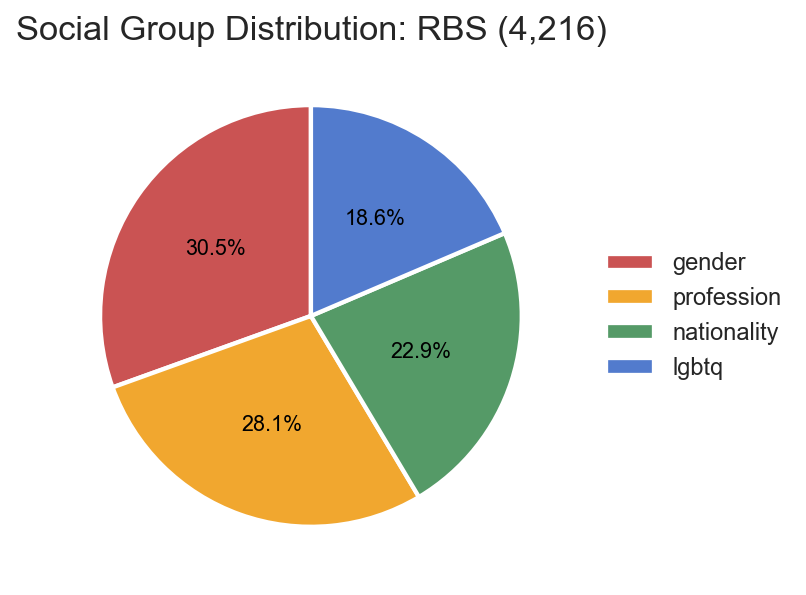

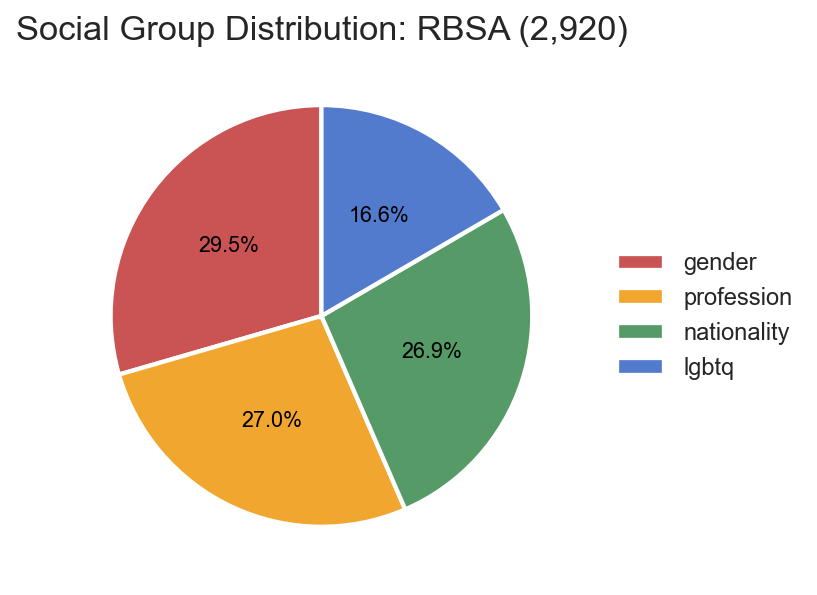

In [56]:
# Plot the pie chart 

# Plot the pie chart 
pie_chart_domain(rubist, column='stereotype_type', name = "RBS (4,216)")

pie_chart_domain(rubist_second, column='stereotype_type', name = "RBSA (2,920)")

In [20]:
# Run EDA
target_dist = prepare_target_variable_distribution(rubist, "category")
group_dist = prepare_group_distribution(rubist, "stereotype_type")
text_length = prepare_text_length_analysis(rubist, "text")
# create_word_cloud(rubist, text_col='text', output_filename='rubist_wordcloud.png')

# Run EDA
target_dist = prepare_target_variable_distribution(rubist_second, "category")
group_dist = prepare_group_distribution(rubist_second, "stereotype_type")
text_length = prepare_text_length_analysis(rubist_second, "text")
# create_word_cloud(rubist_second, text_col='text', output_filename='rubist_second_wordcloud.png')

In [21]:
# Sentiment and Toxicity
rubist_sentiment = analyse_sentiment_and_regard(rubist, text_col="text")
rubist_sentiment.head()
rubist_sentiment.to_csv("COMP0173_Results/rubist_sentiment", index=False, encoding="utf-8-sig")

# Sentiment and Toxicity
rubist_second_sentiment = analyse_sentiment_and_regard(rubist, text_col="text")
rubist_second_sentiment.head()
rubist_second_sentiment.to_csv("COMP0173_Results/rubist_second_sentiment", index=False, encoding="utf-8-sig")

Analyzing Russian Toxicity / Regard: 100%|██████████| 4216/4216 [02:02<00:00, 34.40it/s]


In [22]:
rubist_sentiment = pd.read_csv("COMP0173_Results/rubist_sentiment", encoding="utf-8-sig")
rubist_second_sentiment = pd.read_csv("COMP0173_Results/rubist_second_sentiment", encoding="utf-8-sig")

In [23]:
# Colour maps
SENTIMENT_COLORS = {
    "positive": "#559A67",  
    "neutral":  "#F1A72F",  
    "negative": "#CA5353", 
}

TOXIC_COLORS = {
    "toxic":      "#CA5353",
    "non_toxic":  "#559A67",
}

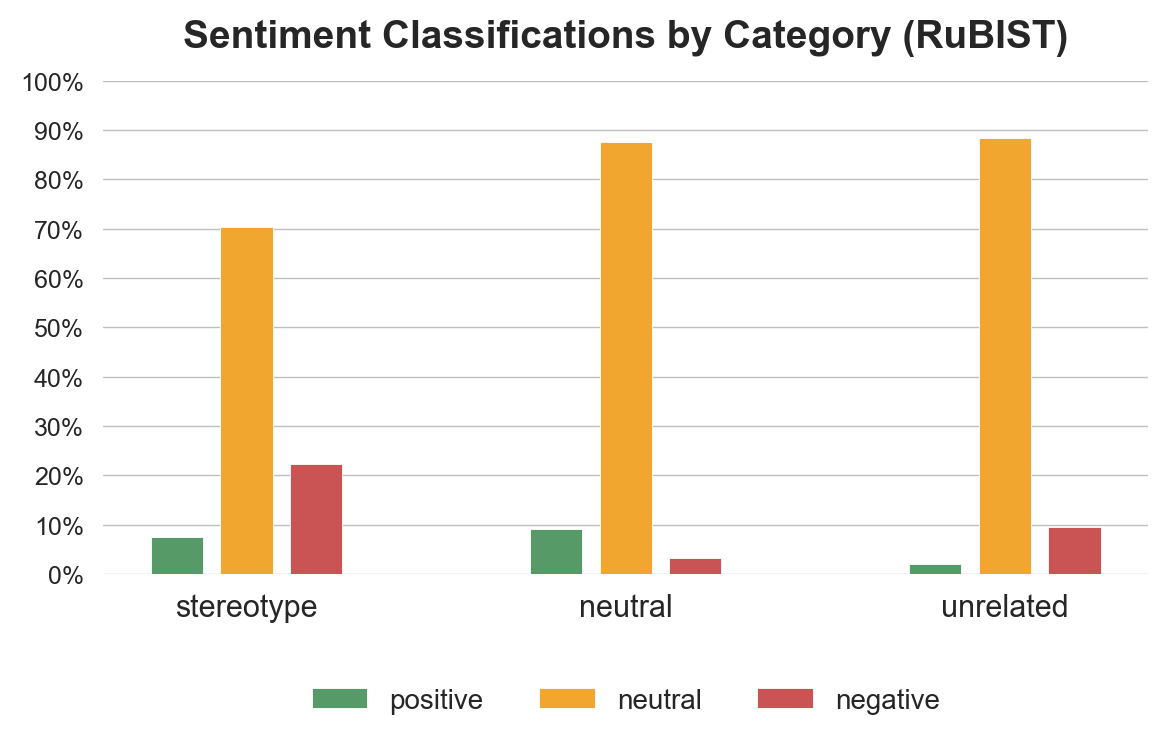

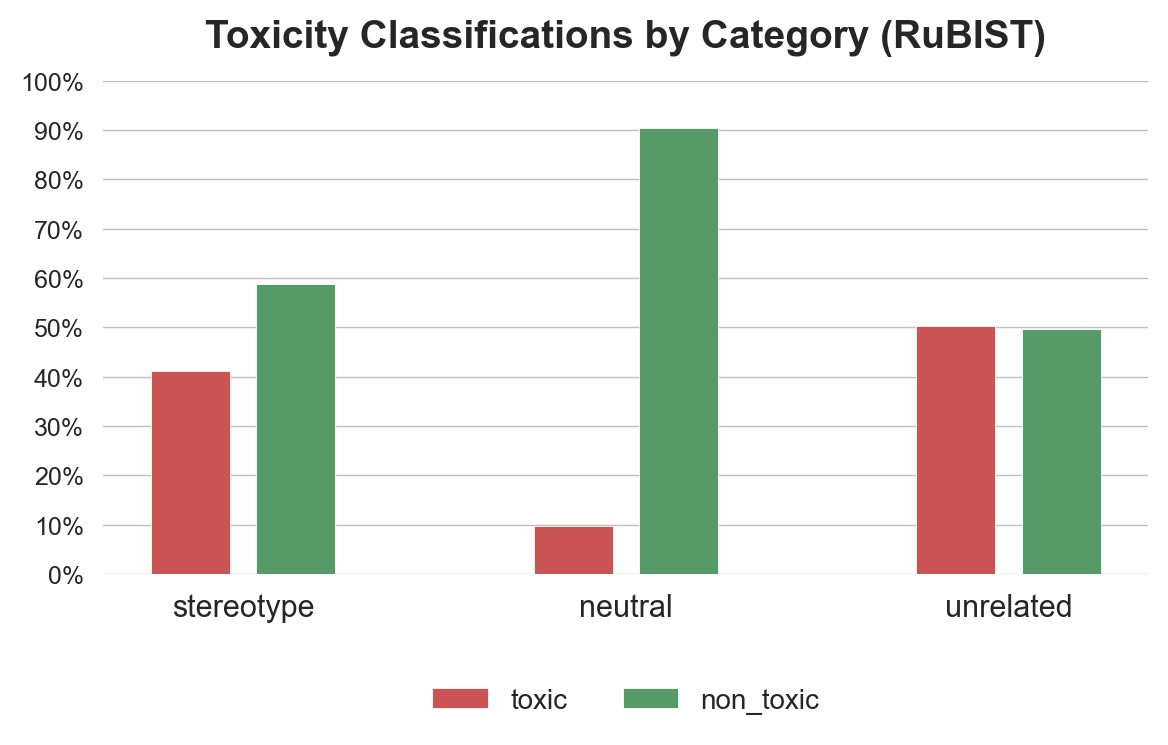

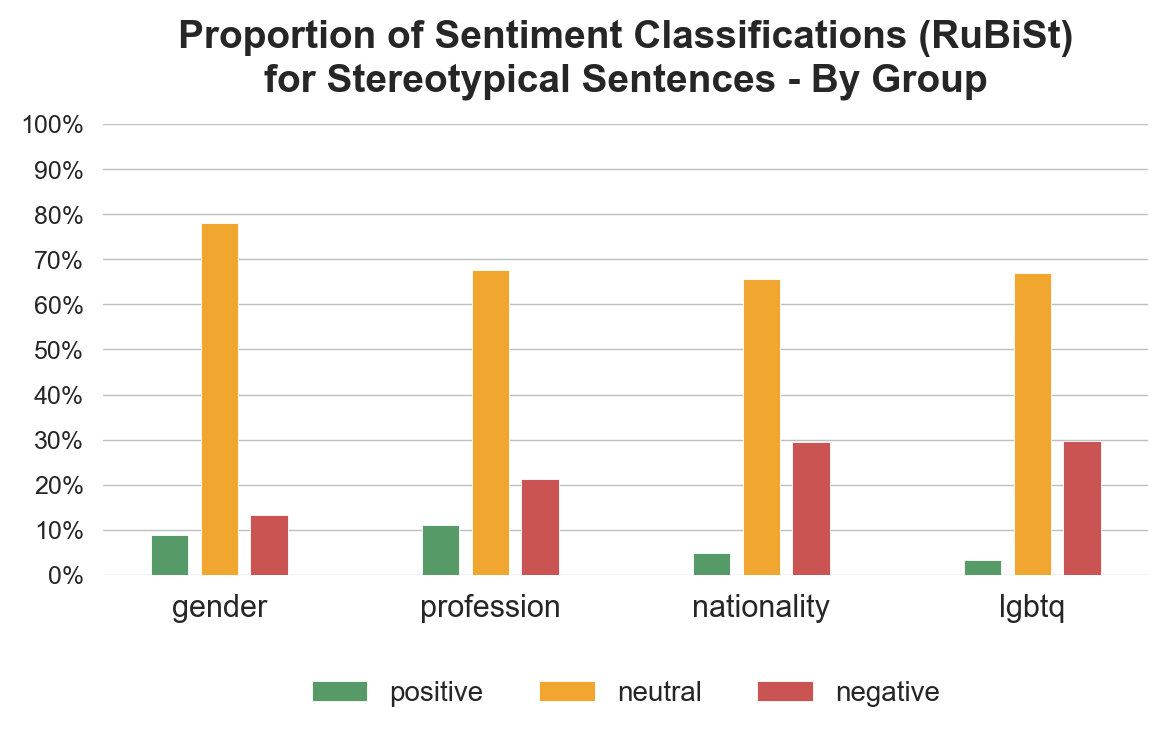

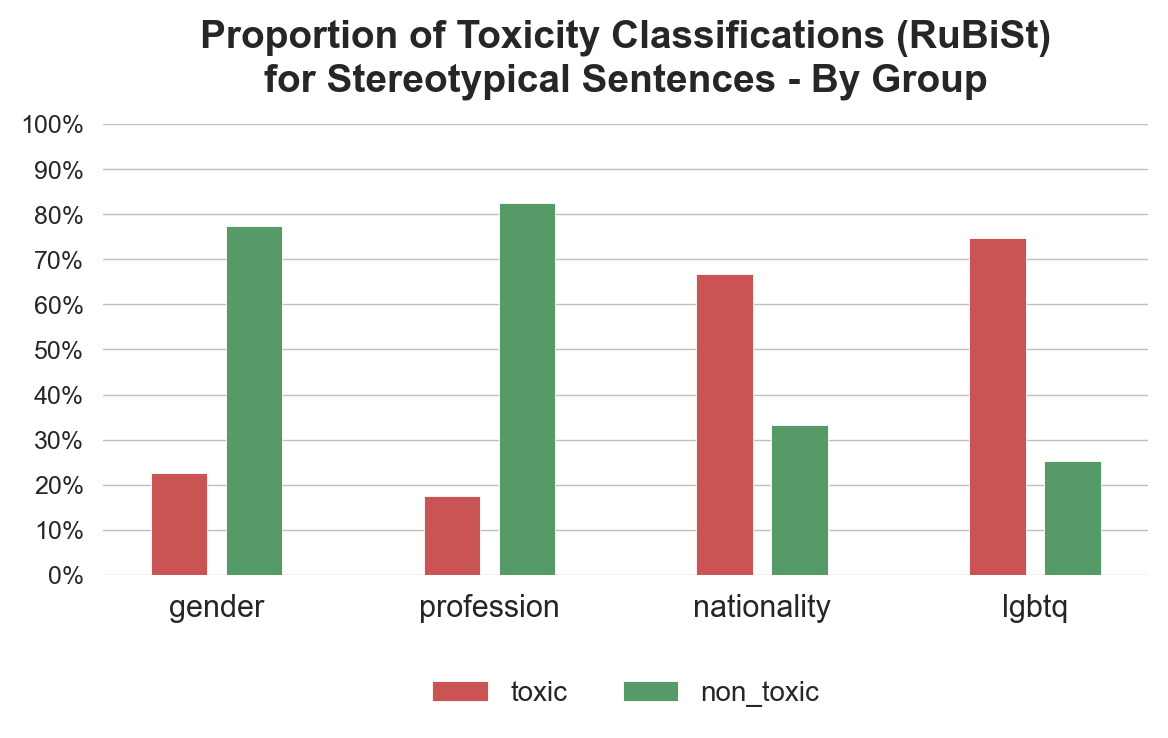

In [48]:
# Generate all four plots
plot_sentiment_by_category(rubist_sentiment, title = "Sentiment Classifications by Category (RuBIST)")
plot_toxic_by_category(rubist_sentiment, title = "Toxicity Classifications by Category (RuBIST)")
plot_sentiment_for_stereotypes_by_group(rubist_sentiment, title = "Proportion of Sentiment Classifications (RuBiSt)\nfor Stereotypical Sentences - By Group")
plot_toxic_for_stereotypes_by_group(rubist_sentiment, title = "Proportion of Toxicity Classifications (RuBiSt)\nfor Stereotypical Sentences - By Group")

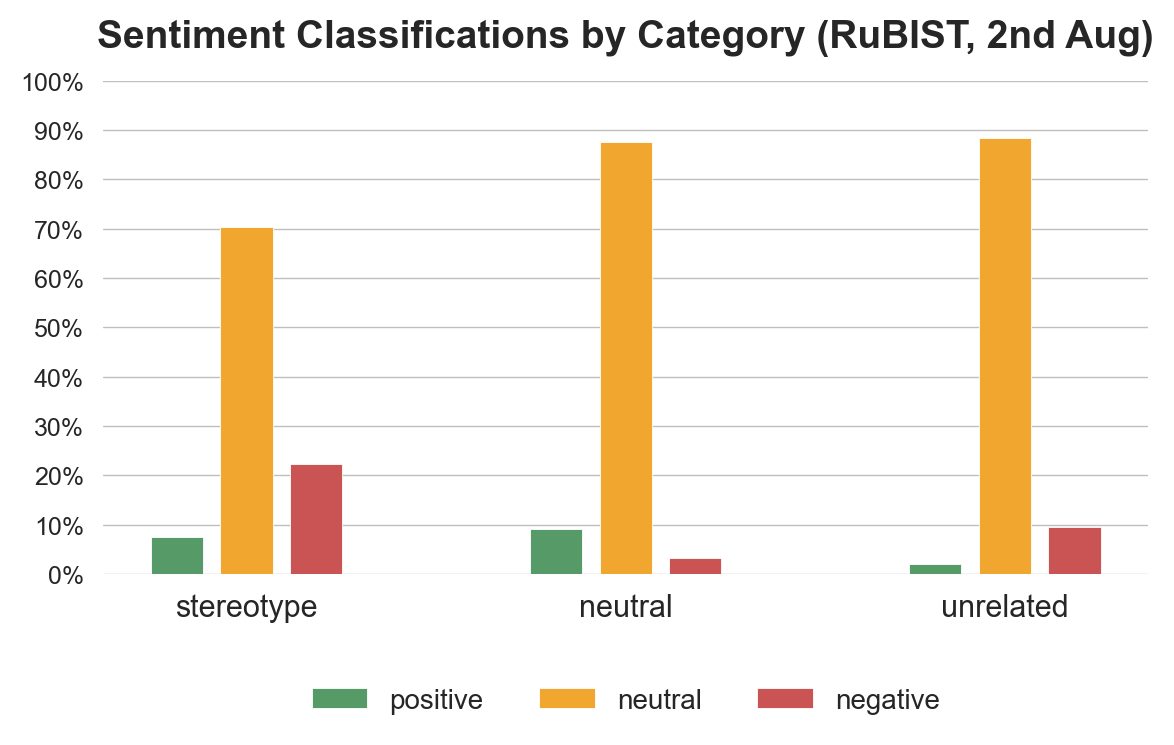

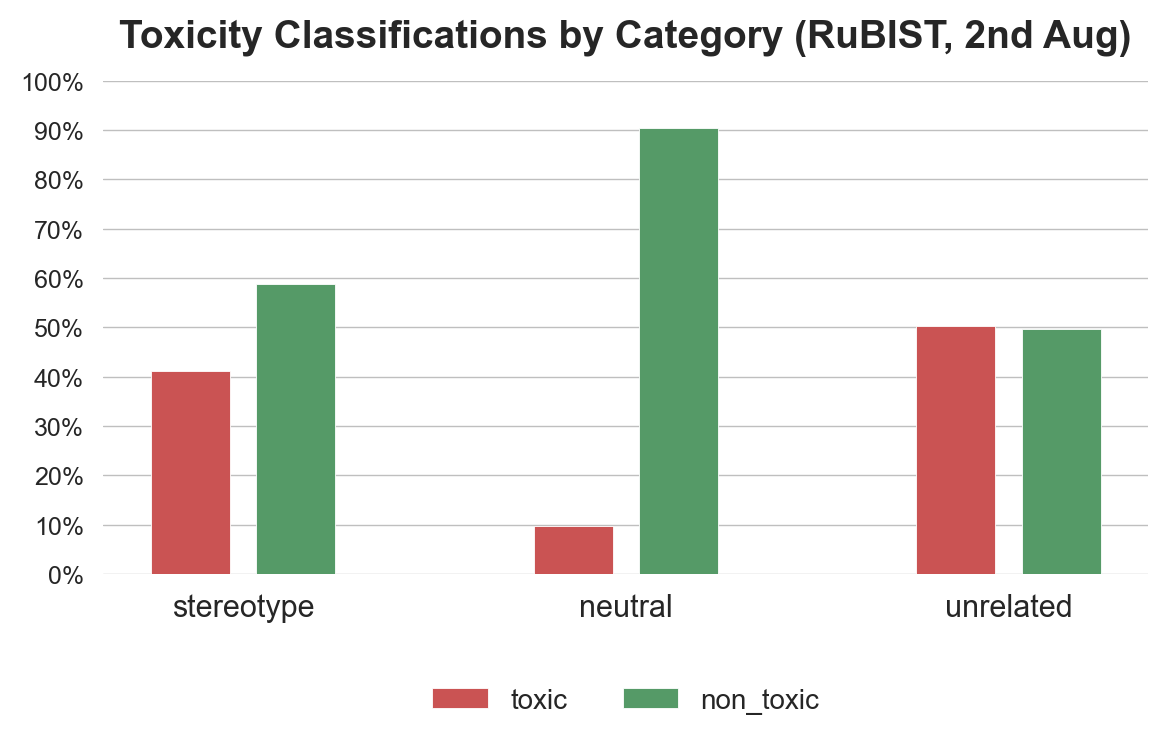

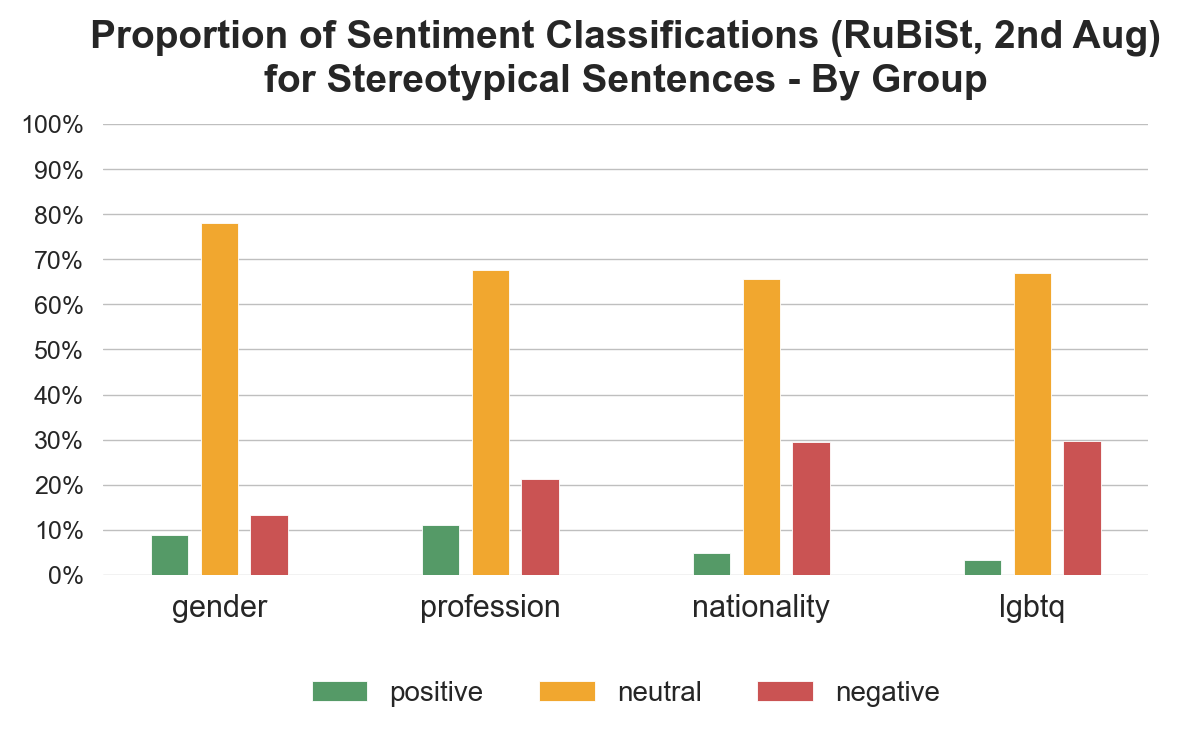

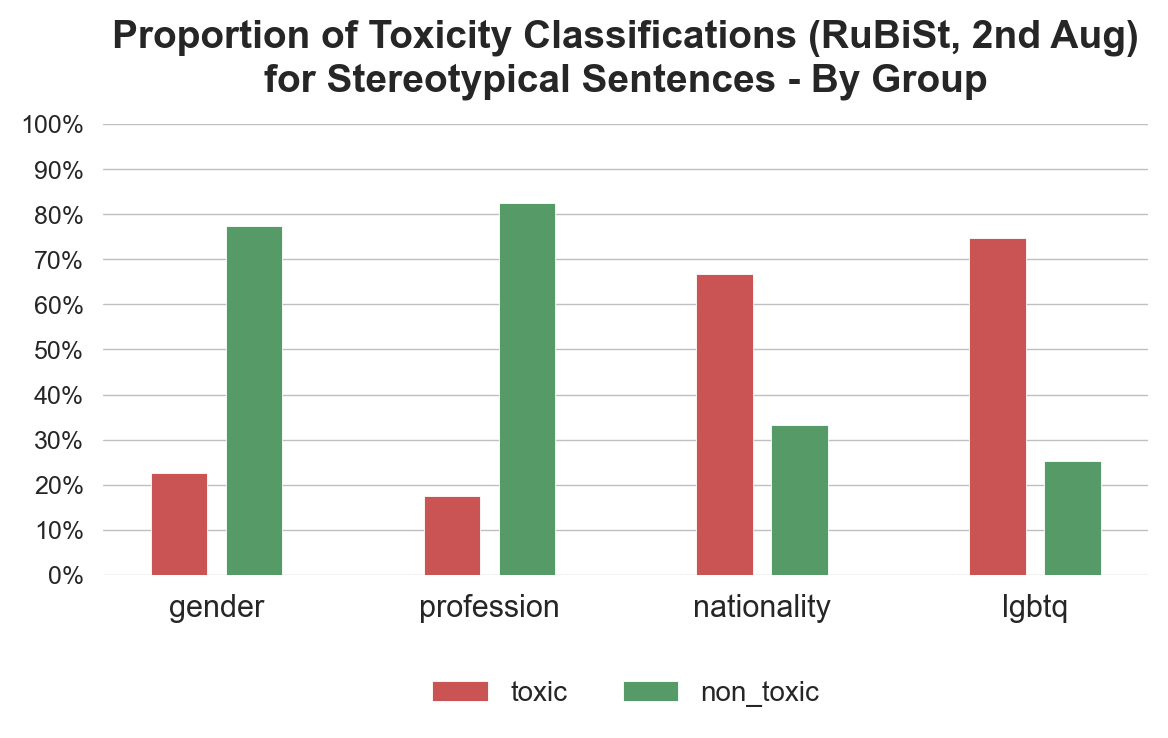

In [50]:
# Generate all four plots
plot_sentiment_by_category(rubist_second_sentiment, title = "Sentiment Classifications by Category (RuBIST, 2nd Aug)")
plot_toxic_by_category(rubist_second_sentiment, title = "Toxicity Classifications by Category (RuBIST, 2nd Aug)")
plot_sentiment_for_stereotypes_by_group(rubist_second_sentiment, title = "Proportion of Sentiment Classifications (RuBiSt, 2nd Aug)\nfor Stereotypical Sentences - By Group")
plot_toxic_for_stereotypes_by_group(rubist_second_sentiment, title = "Proportion of Toxicity Classifications (RuBiSt, 2nd Aug)\nfor Stereotypical Sentences - By Group")

### $\color{pink}{Question\ 2:}$ Document hyperparameter tuning process

#### Train models - Logistic Regression (Spacy Russian)

In [27]:
from Logistic_Regression_Russian import (data_loader, train_model, evaluate_model)

gc.collect()
torch.cuda.empty_cache()

# Load and combine relevant datasets
train_data_rubist, test_data_rubist = data_loader(csv_file_path='COMP0173_Data/rubist.csv', labelling_criteria='stereotype', dataset_name='rubist', sample_size=1000000, num_examples=5)
train_data_rubist_second, test_data_rubist_second = data_loader(csv_file_path='COMP0173_Data/rubist_second.csv', labelling_criteria='stereotype', dataset_name='rubist_second', sample_size=1000000, num_examples=5)


# Execute full pipeline for logistic regression tfidf model
train_model(train_data_rubist, model_output_base_dir='model_output_LR_tfidf', dataset_name='rubist_trained', feature_type='tfidf', seed=42)
evaluate_model(test_data_rubist, model_output_dir='model_output_LR_tfidf/rubist_trained', result_output_base_dir='result_output_LR_tfidf', dataset_name='rubist', feature_type='tfidf', seed=42)

gc.collect()
torch.cuda.empty_cache()

train_model(train_data_rubist_second, model_output_base_dir='model_output_LR_tfidf', dataset_name='rubist_second_trained', feature_type='tfidf', seed=42)
evaluate_model(test_data_rubist_second, model_output_dir='model_output_LR_tfidf/rubist_second_trained', result_output_base_dir='result_output_LR_tfidf', dataset_name='rubist_second', feature_type='tfidf', seed=42)

gc.collect()
torch.cuda.empty_cache()

# Execute full pipeline for logistic regression embedding model
train_model(train_data_rubist, model_output_base_dir='model_output_LR_embedding', dataset_name='rubist_trained', feature_type='embedding', seed=42)
evaluate_model(test_data_rubist, model_output_dir='model_output_LR_embedding/rubist_trained', result_output_base_dir='result_output_LR_embedding', dataset_name='rubist', feature_type='embedding', seed=42)

gc.collect()
torch.cuda.empty_cache()

train_model(train_data_rubist_second, model_output_base_dir='model_output_LR_embedding', dataset_name='rubist_second_trained', feature_type='embedding', seed=42)
evaluate_model(test_data_rubist_second, model_output_dir='model_output_LR_embedding/rubist_second_trained', result_output_base_dir='result_output_LR_embedding', dataset_name='rubist_second', feature_type='embedding', seed=42)

[codecarbon ERROR @ 21:46:39] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:46:39] Another instance of codecarbon is already running. Exiting.


First few examples from the training data:
     stereotype_type                                               text  \
168       profession              футболисты топ клубов следят за модой   
2883     nationality  британцы танцуют с радужными пельменями на кры...   
2919           lgbtq  бисексуалы на самом деле просто сексуально рас...   
3412      profession  программирование доступно людям с разным уровн...   
732            lgbtq        пансексуалы просто до конца не определились   

      category data_name  
168          1    rubist  
2883         0    rubist  
2919         1    rubist  
3412         0    rubist  
732          1    rubist  
First few examples from the testing data:
     stereotype_type                                               text  \
2726      profession  бедные люди питаются звездным светом и варят с...   
1066          gender  женщины водят машины распевая серенады с говор...   
2547     nationality  евреи как и представители других национальност...   
18

[codecarbon WARNING @ 21:46:40] Another instance of codecarbon is already running. Exiting.


Testing C=0.01, penalty=l1 => F1 Score: 0.39785905441570024
Testing C=0.01, penalty=l2 => F1 Score: 0.39785905441570024
Testing C=0.01, penalty=None => F1 Score: 0.9466666666666667
Testing C=0.1, penalty=l1 => F1 Score: 0.6326957285464712
Testing C=0.1, penalty=l2 => F1 Score: 0.6120484633882092
Testing C=0.1, penalty=None => F1 Score: 0.9466666666666667
Testing C=1, penalty=l1 => F1 Score: 0.8929148318366249
Testing C=1, penalty=l2 => F1 Score: 0.8824924844557498
Testing C=1, penalty=None => F1 Score: 0.9466666666666667
Best model parameters: {'C': 0.01, 'penalty': None}
Model and vectorizer saved to model_output_LR_tfidf/rubist_trained
Estimated total emissions: None kg CO2
Number of unique labels: 2


[codecarbon ERROR @ 21:46:41] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:46:41] Another instance of codecarbon is already running. Exiting.


Number of unique labels: 2


[codecarbon WARNING @ 21:46:42] Another instance of codecarbon is already running. Exiting.


Testing C=0.01, penalty=l1 => F1 Score: 0.4
Testing C=0.01, penalty=l2 => F1 Score: 0.4
Testing C=0.01, penalty=None => F1 Score: 0.5407413941385317
Testing C=0.1, penalty=l1 => F1 Score: 0.4
Testing C=0.1, penalty=l2 => F1 Score: 0.4
Testing C=0.1, penalty=None => F1 Score: 0.5407413941385317
Testing C=1, penalty=l1 => F1 Score: 0.46003885576472164
Testing C=1, penalty=l2 => F1 Score: 0.42689732142857145
Testing C=1, penalty=None => F1 Score: 0.5407413941385317
Best model parameters: {'C': 0.01, 'penalty': None}
Model and vectorizer saved to model_output_LR_tfidf/rubist_second_trained
Estimated total emissions: None kg CO2
Number of unique labels: 2


[codecarbon ERROR @ 21:46:43] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:46:43] Another instance of codecarbon is already running. Exiting.


Number of unique labels: 2


Computing embeddings: 100%|██████████| 3372/3372 [00:08<00:00, 394.61it/s]


Testing C=0.01, penalty=l1 => F1 Score: 0.39785905441570024
Testing C=0.01, penalty=l2 => F1 Score: 0.8377403846153846
Testing C=0.01, penalty=None => F1 Score: 0.9196396682408032
Testing C=0.1, penalty=l1 => F1 Score: 0.8833912566306933
Testing C=0.1, penalty=l2 => F1 Score: 0.894211324570273
Testing C=0.1, penalty=None => F1 Score: 0.9196396682408032
Testing C=1, penalty=l1 => F1 Score: 0.9212241604072258
Testing C=1, penalty=l2 => F1 Score: 0.9172978203631145


[codecarbon WARNING @ 21:46:54] Another instance of codecarbon is already running. Exiting.


Testing C=1, penalty=None => F1 Score: 0.9196396682408032
Best model parameters: {'C': 1, 'penalty': 'l1'}
Model and vectorizer saved to model_output_LR_embedding/rubist_trained
Estimated total emissions: None kg CO2
Number of unique labels: 2


Computing embeddings: 100%|██████████| 844/844 [00:02<00:00, 384.55it/s]
[codecarbon ERROR @ 21:46:57] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:46:57] Another instance of codecarbon is already running. Exiting.


Number of unique labels: 2


Computing embeddings: 100%|██████████| 2336/2336 [00:05<00:00, 465.27it/s]


Testing C=0.01, penalty=l1 => F1 Score: 0.4
Testing C=0.01, penalty=l2 => F1 Score: 0.4068829055705911
Testing C=0.01, penalty=None => F1 Score: 0.627725258253562
Testing C=0.1, penalty=l1 => F1 Score: 0.4052597071464996
Testing C=0.1, penalty=l2 => F1 Score: 0.5424300867888139
Testing C=0.1, penalty=None => F1 Score: 0.627725258253562
Testing C=1, penalty=l1 => F1 Score: 0.6112426035502958
Testing C=1, penalty=l2 => F1 Score: 0.6005917159763313


[codecarbon WARNING @ 21:47:04] Another instance of codecarbon is already running. Exiting.


Testing C=1, penalty=None => F1 Score: 0.627725258253562
Best model parameters: {'C': 0.01, 'penalty': None}
Model and vectorizer saved to model_output_LR_embedding/rubist_second_trained
Estimated total emissions: None kg CO2
Number of unique labels: 2


Computing embeddings: 100%|██████████| 584/584 [00:01<00:00, 449.44it/s]


,precision,recall,f1-score,support
0,0.763547,0.796915,0.779874,389.000000
1,0.556180,0.507692,0.530831,195.000000
accuracy,0.700342,0.700342,0.700342,0.700342
macro avg,0.659863,0.652304,0.655353,584.000000
weighted avg,0.694306,0.700342,0.696718,584.000000


#### Train models - DeepPavlov_rubert

In [28]:
import os
os.environ["HF_HOME"] = "/tmp/hf"
os.environ["TRANSFORMERS_CACHE"] = "/tmp/hf"
os.makedirs("/tmp/hf", exist_ok=True)

In [29]:
from BERT_Models_Fine_Tuning_Russian import (data_loader, train_model, evaluate_model)

gc.collect()
torch.cuda.empty_cache()

# Load and combine relevant datasets
train_data_rubist, test_data_rubist = data_loader(csv_file_path='COMP0173_Data/rubist.csv', labelling_criteria='stereotype', dataset_name='rubist', sample_size=1000000, num_examples=5)
train_data_rubist_second, test_data_rubist_second = data_loader(csv_file_path='COMP0173_Data/rubist_second.csv', labelling_criteria='stereotype', dataset_name='rubist_second', sample_size=1000000, num_examples=5)

# Execute full pipeline for Deepavlov model
train_model(train_data_rubist, model_path='DeepPavlov/rubert-base-cased', batch_size=64, epoch=6, learning_rate=2e-5, model_output_base_dir='model_output_deeppavlov_rubert', dataset_name='rubist_trained', seed=42)
evaluate_model(test_data_rubist, model_output_dir='model_output_deeppavlov_rubert/rubist_trained', result_output_base_dir='result_output_deeppavlov_rubert', dataset_name='rubist_trained', seed=42)

gc.collect()
torch.cuda.empty_cache()

train_model(train_data_rubist_second, model_path='DeepPavlov/rubert-base-cased', batch_size=64, epoch=6, learning_rate=2e-5, model_output_base_dir='model_output_deeppavlov_rubert', dataset_name='rubist_second_trained', seed=42)
evaluate_model(test_data_rubist_second, model_output_dir='model_output_deeppavlov_rubert/rubist_second_trained', result_output_base_dir='result_output_deeppavlov_rubert', dataset_name='rubist_second_trained', seed=42)

[codecarbon ERROR @ 21:47:06] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:47:06] Another instance of codecarbon is already running. Exiting.
loading configuration file config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--DeepPavlov--rubert-base-cased/snapshots/4036cab694767a299f2b9e6492909664d9414229/config.json
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": 

First few examples from the training data:
     stereotype_type                                               text  \
168       profession              футболисты топ клубов следят за модой   
2883     nationality  британцы танцуют с радужными пельменями на кры...   
2919           lgbtq  бисексуалы на самом деле просто сексуально рас...   
3412      profession  программирование доступно людям с разным уровн...   
732            lgbtq        пансексуалы просто до конца не определились   

      category data_name  
168          1    rubist  
2883         0    rubist  
2919         1    rubist  
3412         0    rubist  
732          1    rubist  
First few examples from the testing data:
     stereotype_type                                               text  \
2726      profession  бедные люди питаются звездным светом и варят с...   
1066          gender  женщины водят машины распевая серенады с говор...   
2547     nationality  евреи как и представители других национальност...   
18

loading weights file pytorch_model.bin from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--DeepPavlov--rubert-base-cased/snapshots/4036cab694767a299f2b9e6492909664d9414229/pytorch_model.bin
Attempting to create safetensors variant
Attempting to convert .bin model on the fly to safetensors.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTrainin

Sample tokenized input from train: {'stereotype_type': 'gender', 'text': 'женщины принимают важные решения консультируясь с поющими чайниками', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 1317, 'input_ids': [101, 12528, 23558, 29466, 12938, 21264, 57041, 869, 1516, 33165, 27585, 9210, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


Map: 100%|██████████| 675/675 [00:00<00:00, 34342.01 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Sample tokenized input from validation: {'stereotype_type': 'gender', 'text': 'женщины принимают важные решения консультируясь с поющими чайниками', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 1317, 'input_ids': [101, 12528, 23558, 29466, 12938, 21264, 57041, 869, 1516, 33165, 27585, 9210, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 21:47:09] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2,697
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 177,854,978
[codecarbon WARNING @ 21:47:09] Another instance of

{'loss': 0.3709, 'grad_norm': 10.015257835388184, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}


                                                
 17%|█▋        | 43/258 [00:22<02:17,  1.57it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained/checkpoint-43
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-43/config.json


{'eval_loss': 0.16910791397094727, 'eval_precision': 0.925984812529663, 'eval_recall': 0.9422561444310857, 'eval_f1': 0.9331536270950631, 'eval_balanced accuracy': 0.9422561444310857, 'eval_runtime': 1.4625, 'eval_samples_per_second': 461.531, 'eval_steps_per_second': 7.521, 'epoch': 1.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-43/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-43/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-43/special_tokens_map.json
 33%|███▎      | 86/258 [00:45<01:08,  2.50it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.1098, 'grad_norm': 1.2975772619247437, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}


                                                
 33%|███▎      | 86/258 [00:46<01:08,  2.50it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained/checkpoint-86
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-86/config.json


{'eval_loss': 0.10560111701488495, 'eval_precision': 0.9720860566448801, 'eval_recall': 0.9612462305615231, 'eval_f1': 0.966362349751829, 'eval_balanced accuracy': 0.9612462305615231, 'eval_runtime': 1.2687, 'eval_samples_per_second': 532.024, 'eval_steps_per_second': 8.67, 'epoch': 2.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-86/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-86/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-86/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_trained/checkpoint-43] due to args.save_total_limit
 50%|█████     | 129/258 [01:08<00:49,  2.60it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0464, 'grad_norm': 3.4971156120300293, 'learning_rate': 1e-05, 'epoch': 3.0}


                                                 
 50%|█████     | 129/258 [01:10<00:49,  2.60it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained/checkpoint-129
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-129/config.json


{'eval_loss': 0.08520327508449554, 'eval_precision': 0.9625255781630053, 'eval_recall': 0.9722342669058084, 'eval_f1': 0.967093717093717, 'eval_balanced accuracy': 0.9722342669058084, 'eval_runtime': 1.258, 'eval_samples_per_second': 536.57, 'eval_steps_per_second': 8.744, 'epoch': 3.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-129/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-129/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-129/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_trained/checkpoint-86] due to args.save_total_limit
 67%|██████▋   | 172/258 [01:31<00:33,  2.58it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0221, 'grad_norm': 0.046991780400276184, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}


                                                 
 67%|██████▋   | 172/258 [01:32<00:33,  2.58it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained/checkpoint-172
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-172/config.json


{'eval_loss': 0.08270730823278427, 'eval_precision': 0.9715192965315096, 'eval_recall': 0.9755898062557896, 'eval_f1': 0.9735075944895797, 'eval_balanced accuracy': 0.9755898062557896, 'eval_runtime': 1.2368, 'eval_samples_per_second': 545.761, 'eval_steps_per_second': 8.894, 'epoch': 4.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-172/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-172/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-172/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_trained/checkpoint-129] due to args.save_total_limit
 83%|████████▎ | 215/258 [01:54<00:20,  2.14it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0099, 'grad_norm': 0.03969481959939003, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.0}


                                                 
 83%|████████▎ | 215/258 [01:55<00:20,  2.14it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained/checkpoint-215
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-215/config.json


{'eval_loss': 0.11624868959188461, 'eval_precision': 0.9720929538810333, 'eval_recall': 0.9678686165914422, 'eval_f1': 0.9699328872347166, 'eval_balanced accuracy': 0.9678686165914422, 'eval_runtime': 1.2842, 'eval_samples_per_second': 525.609, 'eval_steps_per_second': 8.565, 'epoch': 5.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-215/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-215/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-215/special_tokens_map.json
100%|██████████| 258/258 [02:17<00:00,  2.58it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained/checkpoint-258
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/config.json
Model weights saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_trained/checkpoint-215] due to args.save_t

{'loss': 0.004, 'grad_norm': 0.08230621367692947, 'learning_rate': 0.0, 'epoch': 6.0}


                                                 
100%|██████████| 258/258 [02:22<00:00,  2.58it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained/checkpoint-258
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/config.json


{'eval_loss': 0.12002488970756531, 'eval_precision': 0.9720929538810333, 'eval_recall': 0.9678686165914422, 'eval_f1': 0.9699328872347166, 'eval_balanced accuracy': 0.9678686165914422, 'eval_runtime': 1.2919, 'eval_samples_per_second': 522.496, 'eval_steps_per_second': 8.515, 'epoch': 6.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/checkpoint-258/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model_output_deeppavlov_rubert/rubist_trained/checkpoint-172 (score: 0.08270730823278427).
100%|██████████| 258/258 [02:25<00:00,  2.58it/s]Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_trained/checkpoint-258] due to args.save_total_limit
[codecarbon WARNING @ 21:49:34] Another instance of codecarbon is already running. Exiting.
100%|██████████| 258/258 [02:25<00:00,  1.78it/s]
Saving model checkpoint to model_output_deeppavlov_rubert/rubist_trained
Configuration saved in model_output_deeppavlov_rubert/rubist_trained/config.json


{'train_runtime': 145.0454, 'train_samples_per_second': 111.565, 'train_steps_per_second': 1.779, 'train_loss': 0.09383537868658702, 'epoch': 6.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_trained/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_trained/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_trained/special_tokens_map.json
[codecarbon WARNING @ 21:49:35] Another instance of codecarbon is already running. Exiting.
loading configuration file model_output_deeppavlov_rubert/rubist_trained/config.json
Model config BertConfig {
  "_name_or_path": "model_output_deeppavlov_rubert/rubist_trained",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_

Estimated total emissions: None kg CO2
Number of unique labels: 2


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at model_output_deeppavlov_rubert/rubist_trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Map: 100%|██████████| 844/844 [00:00<00:00, 36831.57 examples/s]


Sample tokenized input from test: {'stereotype_type': 'profession', 'text': 'бедные люди питаются звездным светом и варят суп из радуги', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 2726, 'input_ids': [101, 94818, 11894, 38663, 13904, 2010, 54564, 851, 84652, 868, 10508, 1703, 13158, 23726, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 21:50:05] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:50:05] Another instance of codecarbon is already running. Exiting.
loading configuration file config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--DeepPavlov--rubert-base-cased/snapshots/4036cab694767a299f2b9e6492909664d9414229/config.json
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": 

Number of unique labels: 2


loading weights file pytorch_model.bin from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--DeepPavlov--rubert-base-cased/snapshots/4036cab694767a299f2b9e6492909664d9414229/pytorch_model.bin
Attempting to create safetensors variant
Attempting to convert .bin model on the fly to safetensors.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTrainin

Sample tokenized input from train: {'stereotype_type': 'nationality', 'text': 'все эстонцы очень пушистые', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 1567, 'input_ids': [101, 4752, 92660, 4402, 7805, 14741, 23939, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


Map: 100%|██████████| 468/468 [00:00<00:00, 30080.98 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Sample tokenized input from validation: {'stereotype_type': 'nationality', 'text': 'все эстонцы очень пушистые', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 1567, 'input_ids': [101, 4752, 92660, 4402, 7805, 14741, 23939, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 21:50:08] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1,868
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 180
  Number of trainable parameters = 177,854,978
[codecarbon WARNING @ 21:50:08] Another instance of

{'loss': 0.6411, 'grad_norm': 6.413757801055908, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}



 17%|█▋        | 30/180 [00:15<01:18,  1.91it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-30
Configuration saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-30/config.json


{'eval_loss': 0.6272999048233032, 'eval_precision': 0.6567433822951849, 'eval_recall': 0.5394906097247234, 'eval_f1': 0.4875585119487559, 'eval_balanced accuracy': 0.5394906097247234, 'eval_runtime': 0.9133, 'eval_samples_per_second': 512.415, 'eval_steps_per_second': 8.759, 'epoch': 1.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-30/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-30/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-30/special_tokens_map.json
 33%|███▎      | 60/180 [00:32<00:48,  2.48it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.5509, 'grad_norm': 19.458295822143555, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}



 33%|███▎      | 60/180 [00:32<00:48,  2.48it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-60
Configuration saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-60/config.json


{'eval_loss': 0.5725044012069702, 'eval_precision': 0.6757306282956475, 'eval_recall': 0.6556470285567275, 'eval_f1': 0.6608324339542959, 'eval_balanced accuracy': 0.6556470285567275, 'eval_runtime': 0.6956, 'eval_samples_per_second': 672.774, 'eval_steps_per_second': 11.5, 'epoch': 2.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-60/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-60/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-60/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-30] due to args.save_total_limit
 50%|█████     | 90/180 [00:49<00:35,  2.54it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.4264, 'grad_norm': 14.432291030883789, 'learning_rate': 1e-05, 'epoch': 3.0}



 50%|█████     | 90/180 [00:50<00:35,  2.54it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-90
Configuration saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-90/config.json


{'eval_loss': 0.5320208668708801, 'eval_precision': 0.7316204051012754, 'eval_recall': 0.6955235400051454, 'eval_f1': 0.7043933354211009, 'eval_balanced accuracy': 0.6955235400051454, 'eval_runtime': 0.6889, 'eval_samples_per_second': 679.309, 'eval_steps_per_second': 11.612, 'epoch': 3.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-90/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-90/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-90/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-60] due to args.save_total_limit
 67%|██████▋   | 120/180 [01:07<00:25,  2.33it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.3419, 'grad_norm': 15.026641845703125, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}



 67%|██████▋   | 120/180 [01:07<00:25,  2.33it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-120
Configuration saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-120/config.json


{'eval_loss': 0.5071310997009277, 'eval_precision': 0.7437499999999999, 'eval_recall': 0.7500643169539492, 'eval_f1': 0.7464256600752698, 'eval_balanced accuracy': 0.7500643169539492, 'eval_runtime': 0.6964, 'eval_samples_per_second': 672.042, 'eval_steps_per_second': 11.488, 'epoch': 4.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-120/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-120/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-120/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-90] due to args.save_total_limit
 83%|████████▎ | 150/180 [01:24<00:11,  2.55it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.2746, 'grad_norm': 11.936842918395996, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.0}



 83%|████████▎ | 150/180 [01:24<00:11,  2.55it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-150
Configuration saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-150/config.json


{'eval_loss': 0.5292905569076538, 'eval_precision': 0.7569815686587409, 'eval_recall': 0.7549524054540777, 'eval_f1': 0.7559291727717485, 'eval_balanced accuracy': 0.7549524054540777, 'eval_runtime': 0.6852, 'eval_samples_per_second': 683.056, 'eval_steps_per_second': 11.676, 'epoch': 5.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-150/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-150/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-150/special_tokens_map.json
100%|██████████| 180/180 [01:41<00:00,  2.50it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180
Configuration saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/config.json
Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/special_tokens_map.json
Deleting older checkpoint [model_output_deeppavlov_

{'loss': 0.2441, 'grad_norm': 26.797395706176758, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 180/180 [01:44<00:00,  2.50it/s]Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180
Configuration saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/config.json


{'eval_loss': 0.5395951271057129, 'eval_precision': 0.7592655221119223, 'eval_recall': 0.7579109853357344, 'eval_f1': 0.7585714285714286, 'eval_balanced accuracy': 0.7579109853357344, 'eval_runtime': 0.7239, 'eval_samples_per_second': 646.495, 'eval_steps_per_second': 11.051, 'epoch': 6.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-120 (score: 0.5071310997009277).
100%|██████████| 180/180 [01:47<00:00,  2.50it/s]Deleting older checkpoint [model_output_deeppavlov_rubert/rubist_second_trained/checkpoint-180] due to args.save_total_limit
[codecarbon WARNING @ 21:51:55] Another instance of codecarbon is already running. Exiting.
100%|██████████| 180/180 [01:47<00:00,  1.67it/s]
Saving model checkpoint to model_output_deeppavlov_rubert/rubist_second_trained
Configuration saved in model_output_deeppavlov

{'train_runtime': 107.4525, 'train_samples_per_second': 104.307, 'train_steps_per_second': 1.675, 'train_loss': 0.41316156917148167, 'epoch': 6.0}


Model weights saved in model_output_deeppavlov_rubert/rubist_second_trained/model.safetensors
tokenizer config file saved in model_output_deeppavlov_rubert/rubist_second_trained/tokenizer_config.json
Special tokens file saved in model_output_deeppavlov_rubert/rubist_second_trained/special_tokens_map.json
[codecarbon WARNING @ 21:51:56] Another instance of codecarbon is already running. Exiting.
loading configuration file model_output_deeppavlov_rubert/rubist_second_trained/config.json
Model config BertConfig {
  "_name_or_path": "model_output_deeppavlov_rubert/rubist_second_trained",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  

Estimated total emissions: None kg CO2
Number of unique labels: 2


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at model_output_deeppavlov_rubert/rubist_second_trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Map: 100%|██████████| 584/584 [00:00<00:00, 29694.55 examples/s]


Sample tokenized input from test: {'stereotype_type': 'profession', 'text': 'чтобы быть музыкантом нужно иметь шкаф', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 80, 'input_ids': [101, 5247, 6345, 44670, 15411, 16038, 74989, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


,precision,recall,f1-score,support
0,0.821333,0.791774,0.806283,389.000000
1,0.612440,0.656410,0.633663,195.000000
accuracy,0.746575,0.746575,0.746575,0.746575
macro avg,0.716887,0.724092,0.719973,584.000000
weighted avg,0.751583,0.746575,0.748644,584.000000


#### Train models - roberta_base

In [30]:
from BERT_Models_Fine_Tuning_Russian import (data_loader, train_model, evaluate_model)

gc.collect()
torch.cuda.empty_cache()

# Load and combine relevant datasets
train_data_rubist, test_data_rubist = data_loader(csv_file_path='COMP0173_Data/rubist.csv', labelling_criteria='stereotype', dataset_name='rubist', sample_size=1000000, num_examples=5)
train_data_rubist_second, test_data_rubist_second = data_loader(csv_file_path='COMP0173_Data/rubist_second.csv', labelling_criteria='stereotype', dataset_name='rubist_second', sample_size=1000000, num_examples=5)

# Execute full pipeline for Deepavlov model
train_model(train_data_rubist, model_path='ai-forever/ruBert-base', batch_size=64, epoch=6, learning_rate=2e-5, model_output_base_dir='model_output_ruberta_base', dataset_name='rubist_trained', seed=42)
evaluate_model(test_data_rubist, model_output_dir='model_output_ruberta_base/rubist_trained', result_output_base_dir='result_output_ruberta_base', dataset_name='rubist_trained', seed=42)

gc.collect()
torch.cuda.empty_cache()

train_model(train_data_rubist_second, model_path='ai-forever/ruBert-base', batch_size=64, epoch=6, learning_rate=2e-5, model_output_base_dir='model_output_ruberta_base', dataset_name='rubist_second_trained', seed=42)
evaluate_model(test_data_rubist_second, model_output_dir='model_output_ruberta_base/rubist_second_trained', result_output_base_dir='result_output_ruberta_base', dataset_name='rubist_second_trained', seed=42)

[codecarbon ERROR @ 21:52:16] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:52:16] Another instance of codecarbon is already running. Exiting.


First few examples from the training data:
     stereotype_type                                               text  \
168       profession              футболисты топ клубов следят за модой   
2883     nationality  британцы танцуют с радужными пельменями на кры...   
2919           lgbtq  бисексуалы на самом деле просто сексуально рас...   
3412      profession  программирование доступно людям с разным уровн...   
732            lgbtq        пансексуалы просто до конца не определились   

      category data_name  
168          1    rubist  
2883         0    rubist  
2919         1    rubist  
3412         0    rubist  
732          1    rubist  
First few examples from the testing data:
     stereotype_type                                               text  \
2726      profession  бедные люди питаются звездным светом и варят с...   
1066          gender  женщины водят машины распевая серенады с говор...   
2547     nationality  евреи как и представители других национальност...   
18

loading configuration file config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--ai-forever--ruBert-base/snapshots/05f37a2ca9e333fd18f30cd0c96c68d274793c69/config.json
Model config BertConfig {
  "_name_or_path": "ai-forever/ruBert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_

Sample tokenized input from train: {'stereotype_type': 'gender', 'text': 'женщины принимают важные решения консультируясь с поющими чайниками', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 1317, 'input_ids': [101, 4269, 12924, 15663, 3822, 16375, 52066, 699, 110, 102821, 5897, 921, 82766, 1306, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


Map: 100%|██████████| 675/675 [00:00<00:00, 33659.35 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Sample tokenized input from validation: {'stereotype_type': 'gender', 'text': 'женщины принимают важные решения консультируясь с поющими чайниками', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 1317, 'input_ids': [101, 4269, 12924, 15663, 3822, 16375, 52066, 699, 110, 102821, 5897, 921, 82766, 1306, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 21:53:56] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2,697
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 178,308,866
[codecarbon WARNING @ 21:53:56] Another instance of

{'loss': 0.2959, 'grad_norm': 3.8145382404327393, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}


                                                
 17%|█▋        | 43/258 [00:23<01:49,  1.97it/s]Saving model checkpoint to model_output_ruberta_base/rubist_trained/checkpoint-43
Configuration saved in model_output_ruberta_base/rubist_trained/checkpoint-43/config.json


{'eval_loss': 0.08393458276987076, 'eval_precision': 0.9563186813186813, 'eval_recall': 0.9501399373238465, 'eval_f1': 0.9531231398071351, 'eval_balanced accuracy': 0.9501399373238465, 'eval_runtime': 1.486, 'eval_samples_per_second': 454.237, 'eval_steps_per_second': 7.402, 'epoch': 1.0}


Model weights saved in model_output_ruberta_base/rubist_trained/checkpoint-43/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/checkpoint-43/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/checkpoint-43/special_tokens_map.json
 33%|███▎      | 86/258 [00:46<01:10,  2.46it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0561, 'grad_norm': 4.915772914886475, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}


                                                
 33%|███▎      | 86/258 [00:47<01:10,  2.46it/s]Saving model checkpoint to model_output_ruberta_base/rubist_trained/checkpoint-86
Configuration saved in model_output_ruberta_base/rubist_trained/checkpoint-86/config.json


{'eval_loss': 0.0658872127532959, 'eval_precision': 0.9730943659515088, 'eval_recall': 0.9811133886512802, 'eval_f1': 0.9769174401563263, 'eval_balanced accuracy': 0.9811133886512802, 'eval_runtime': 1.385, 'eval_samples_per_second': 487.35, 'eval_steps_per_second': 7.942, 'epoch': 2.0}


Model weights saved in model_output_ruberta_base/rubist_trained/checkpoint-86/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/checkpoint-86/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/checkpoint-86/special_tokens_map.json
Deleting older checkpoint [model_output_ruberta_base/rubist_trained/checkpoint-43] due to args.save_total_limit
 50%|█████     | 129/258 [01:11<00:55,  2.31it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0166, 'grad_norm': 0.13193808495998383, 'learning_rate': 1e-05, 'epoch': 3.0}


                                                 
 50%|█████     | 129/258 [01:13<00:55,  2.31it/s]Saving model checkpoint to model_output_ruberta_base/rubist_trained/checkpoint-129
Configuration saved in model_output_ruberta_base/rubist_trained/checkpoint-129/config.json


{'eval_loss': 0.07603797316551208, 'eval_precision': 0.9754265801490026, 'eval_recall': 0.9678833987031161, 'eval_f1': 0.9715066112111241, 'eval_balanced accuracy': 0.9678833987031161, 'eval_runtime': 1.4184, 'eval_samples_per_second': 475.897, 'eval_steps_per_second': 7.755, 'epoch': 3.0}


Model weights saved in model_output_ruberta_base/rubist_trained/checkpoint-129/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/checkpoint-129/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/checkpoint-129/special_tokens_map.json
 67%|██████▋   | 172/258 [01:36<00:36,  2.32it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0098, 'grad_norm': 0.03334636613726616, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}


                                                 
 67%|██████▋   | 172/258 [01:37<00:36,  2.32it/s]Saving model checkpoint to model_output_ruberta_base/rubist_trained/checkpoint-172
Configuration saved in model_output_ruberta_base/rubist_trained/checkpoint-172/config.json


{'eval_loss': 0.07533005625009537, 'eval_precision': 0.9754489588926676, 'eval_recall': 0.9711945917180755, 'eval_f1': 0.9732736775419703, 'eval_balanced accuracy': 0.9711945917180755, 'eval_runtime': 1.4163, 'eval_samples_per_second': 476.589, 'eval_steps_per_second': 7.767, 'epoch': 4.0}


Model weights saved in model_output_ruberta_base/rubist_trained/checkpoint-172/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/checkpoint-172/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/checkpoint-172/special_tokens_map.json
Deleting older checkpoint [model_output_ruberta_base/rubist_trained/checkpoint-129] due to args.save_total_limit
 83%|████████▎ | 215/258 [02:00<00:18,  2.36it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0043, 'grad_norm': 0.03415057808160782, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.0}


                                                 
 83%|████████▎ | 215/258 [02:02<00:18,  2.36it/s]Saving model checkpoint to model_output_ruberta_base/rubist_trained/checkpoint-215
Configuration saved in model_output_ruberta_base/rubist_trained/checkpoint-215/config.json


{'eval_loss': 0.07625529170036316, 'eval_precision': 0.9790562816437066, 'eval_recall': 0.981142952874628, 'eval_f1': 0.9800877123977345, 'eval_balanced accuracy': 0.981142952874628, 'eval_runtime': 1.4638, 'eval_samples_per_second': 461.129, 'eval_steps_per_second': 7.515, 'epoch': 5.0}


Model weights saved in model_output_ruberta_base/rubist_trained/checkpoint-215/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/checkpoint-215/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/checkpoint-215/special_tokens_map.json
Deleting older checkpoint [model_output_ruberta_base/rubist_trained/checkpoint-172] due to args.save_total_limit
100%|██████████| 258/258 [02:26<00:00,  2.37it/s]Saving model checkpoint to model_output_ruberta_base/rubist_trained/checkpoint-258
Configuration saved in model_output_ruberta_base/rubist_trained/checkpoint-258/config.json
Model weights saved in model_output_ruberta_base/rubist_trained/checkpoint-258/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/checkpoint-258/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/checkpoint-258/special_tokens_map.json
Deleting older checkpoint [model_o

{'loss': 0.0036, 'grad_norm': 0.031562238931655884, 'learning_rate': 0.0, 'epoch': 6.0}


                                                 
100%|██████████| 258/258 [02:29<00:00,  2.37it/s]Saving model checkpoint to model_output_ruberta_base/rubist_trained/checkpoint-258
Configuration saved in model_output_ruberta_base/rubist_trained/checkpoint-258/config.json


{'eval_loss': 0.07891009002923965, 'eval_precision': 0.9755555555555555, 'eval_recall': 0.9745057847330351, 'eval_f1': 0.9750276853562347, 'eval_balanced accuracy': 0.9745057847330351, 'eval_runtime': 1.4785, 'eval_samples_per_second': 456.555, 'eval_steps_per_second': 7.44, 'epoch': 6.0}


Model weights saved in model_output_ruberta_base/rubist_trained/checkpoint-258/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/checkpoint-258/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/checkpoint-258/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model_output_ruberta_base/rubist_trained/checkpoint-86 (score: 0.0658872127532959).
100%|██████████| 258/258 [02:32<00:00,  2.37it/s]Deleting older checkpoint [model_output_ruberta_base/rubist_trained/checkpoint-258] due to args.save_total_limit
[codecarbon WARNING @ 21:56:28] Another instance of codecarbon is already running. Exiting.
100%|██████████| 258/258 [02:32<00:00,  1.70it/s]
Saving model checkpoint to model_output_ruberta_base/rubist_trained
Configuration saved in model_output_ruberta_base/rubist_trained/config.json


{'train_runtime': 152.1394, 'train_samples_per_second': 106.363, 'train_steps_per_second': 1.696, 'train_loss': 0.06437857656977898, 'epoch': 6.0}


Model weights saved in model_output_ruberta_base/rubist_trained/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_trained/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_trained/special_tokens_map.json
[codecarbon WARNING @ 21:56:29] Another instance of codecarbon is already running. Exiting.
loading configuration file model_output_ruberta_base/rubist_trained/config.json
Model config BertConfig {
  "_name_or_path": "model_output_ruberta_base/rubist_trained",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_s

Estimated total emissions: None kg CO2
Number of unique labels: 2


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at model_output_ruberta_base/rubist_trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Map: 100%|██████████| 844/844 [00:00<00:00, 32068.35 examples/s]


Sample tokenized input from test: {'stereotype_type': 'profession', 'text': 'бедные люди питаются звездным светом и варят суп из радуги', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 2726, 'input_ids': [101, 42890, 1950, 47937, 10088, 815, 16465, 107, 84625, 18777, 734, 74394, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 21:56:59] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:56:59] Another instance of codecarbon is already running. Exiting.
loading configuration file config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--ai-forever--ruBert-base/snapshots/05f37a2ca9e333fd18f30cd0c96c68d274793c69/config.json
Model config BertConfig {
  "_name_or_path": "ai-forever/ruBert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert"

Number of unique labels: 2


loading weights file pytorch_model.bin from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--ai-forever--ruBert-base/snapshots/05f37a2ca9e333fd18f30cd0c96c68d274793c69/pytorch_model.bin
Attempting to create safetensors variant
Attempting to convert .bin model on the fly to safetensors.
Some weights of the model checkpoint at ai-forever/ruBert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- 

Sample tokenized input from train: {'stereotype_type': 'nationality', 'text': 'все эстонцы очень пушистые', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 1567, 'input_ids': [101, 780, 34330, 1048, 1179, 94517, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


Map: 100%|██████████| 468/468 [00:00<00:00, 30534.40 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Sample tokenized input from validation: {'stereotype_type': 'nationality', 'text': 'все эстонцы очень пушистые', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 1567, 'input_ids': [101, 780, 34330, 1048, 1179, 94517, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 21:57:02] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1,868
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 180
  Number of trainable parameters = 178,308,866
[codecarbon WARNING @ 21:57:02] Another instance of

{'loss': 0.6243, 'grad_norm': 5.661255836486816, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}



 17%|█▋        | 30/180 [00:15<01:18,  1.91it/s]Saving model checkpoint to model_output_ruberta_base/rubist_second_trained/checkpoint-30
Configuration saved in model_output_ruberta_base/rubist_second_trained/checkpoint-30/config.json


{'eval_loss': 0.5886918306350708, 'eval_precision': 0.7438852605967474, 'eval_recall': 0.6130692050424492, 'eval_f1': 0.6033403963604637, 'eval_balanced accuracy': 0.6130692050424492, 'eval_runtime': 0.9638, 'eval_samples_per_second': 485.572, 'eval_steps_per_second': 8.3, 'epoch': 1.0}


Model weights saved in model_output_ruberta_base/rubist_second_trained/checkpoint-30/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-30/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-30/special_tokens_map.json
 33%|███▎      | 60/180 [00:31<00:48,  2.47it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.488, 'grad_norm': 14.586087226867676, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}



 33%|███▎      | 60/180 [00:31<00:48,  2.47it/s]Saving model checkpoint to model_output_ruberta_base/rubist_second_trained/checkpoint-60
Configuration saved in model_output_ruberta_base/rubist_second_trained/checkpoint-60/config.json


{'eval_loss': 0.459627240896225, 'eval_precision': 0.7525417574437182, 'eval_recall': 0.7477489066117828, 'eval_f1': 0.7499388279943073, 'eval_balanced accuracy': 0.7477489066117828, 'eval_runtime': 0.7523, 'eval_samples_per_second': 622.052, 'eval_steps_per_second': 10.633, 'epoch': 2.0}


Model weights saved in model_output_ruberta_base/rubist_second_trained/checkpoint-60/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-60/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-60/special_tokens_map.json
Deleting older checkpoint [model_output_ruberta_base/rubist_second_trained/checkpoint-30] due to args.save_total_limit
 50%|█████     | 90/180 [00:48<00:35,  2.50it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.3037, 'grad_norm': 14.871849060058594, 'learning_rate': 1e-05, 'epoch': 3.0}



 50%|█████     | 90/180 [00:49<00:35,  2.50it/s]Saving model checkpoint to model_output_ruberta_base/rubist_second_trained/checkpoint-90
Configuration saved in model_output_ruberta_base/rubist_second_trained/checkpoint-90/config.json


{'eval_loss': 0.45848748087882996, 'eval_precision': 0.7938829787234043, 'eval_recall': 0.8061487007975303, 'eval_f1': 0.7984934906605129, 'eval_balanced accuracy': 0.8061487007975303, 'eval_runtime': 0.7533, 'eval_samples_per_second': 621.252, 'eval_steps_per_second': 10.62, 'epoch': 3.0}


Model weights saved in model_output_ruberta_base/rubist_second_trained/checkpoint-90/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-90/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-90/special_tokens_map.json
Deleting older checkpoint [model_output_ruberta_base/rubist_second_trained/checkpoint-60] due to args.save_total_limit
 67%|██████▋   | 120/180 [01:05<00:24,  2.40it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.2171, 'grad_norm': 16.810762405395508, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}



 67%|██████▋   | 120/180 [01:05<00:24,  2.40it/s]Saving model checkpoint to model_output_ruberta_base/rubist_second_trained/checkpoint-120
Configuration saved in model_output_ruberta_base/rubist_second_trained/checkpoint-120/config.json


{'eval_loss': 0.515616238117218, 'eval_precision': 0.7862770108043218, 'eval_recall': 0.8020324157447903, 'eval_f1': 0.7911666626682341, 'eval_balanced accuracy': 0.8020324157447903, 'eval_runtime': 0.7574, 'eval_samples_per_second': 617.894, 'eval_steps_per_second': 10.562, 'epoch': 4.0}


Model weights saved in model_output_ruberta_base/rubist_second_trained/checkpoint-120/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-120/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-120/special_tokens_map.json
 83%|████████▎ | 150/180 [01:21<00:11,  2.62it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.1587, 'grad_norm': 8.610406875610352, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.0}



 83%|████████▎ | 150/180 [01:22<00:11,  2.62it/s]Saving model checkpoint to model_output_ruberta_base/rubist_second_trained/checkpoint-150
Configuration saved in model_output_ruberta_base/rubist_second_trained/checkpoint-150/config.json


{'eval_loss': 0.5159018039703369, 'eval_precision': 0.7980882007975604, 'eval_recall': 0.8017751479289941, 'eval_f1': 0.7998220246903869, 'eval_balanced accuracy': 0.8017751479289941, 'eval_runtime': 0.7525, 'eval_samples_per_second': 621.946, 'eval_steps_per_second': 10.632, 'epoch': 5.0}


Model weights saved in model_output_ruberta_base/rubist_second_trained/checkpoint-150/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-150/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-150/special_tokens_map.json
Deleting older checkpoint [model_output_ruberta_base/rubist_second_trained/checkpoint-120] due to args.save_total_limit
100%|██████████| 180/180 [01:38<00:00,  2.51it/s]Saving model checkpoint to model_output_ruberta_base/rubist_second_trained/checkpoint-180
Configuration saved in model_output_ruberta_base/rubist_second_trained/checkpoint-180/config.json
Model weights saved in model_output_ruberta_base/rubist_second_trained/checkpoint-180/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-180/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/checkpoint

{'loss': 0.1281, 'grad_norm': 12.326067924499512, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 180/180 [01:41<00:00,  2.51it/s]Saving model checkpoint to model_output_ruberta_base/rubist_second_trained/checkpoint-180
Configuration saved in model_output_ruberta_base/rubist_second_trained/checkpoint-180/config.json
Model weights saved in model_output_ruberta_base/rubist_second_trained/checkpoint-180/model.safetensors


{'eval_loss': 0.5239155888557434, 'eval_precision': 0.8008747105737073, 'eval_recall': 0.8008747105737073, 'eval_f1': 0.8008747105737073, 'eval_balanced accuracy': 0.8008747105737073, 'eval_runtime': 0.7883, 'eval_samples_per_second': 593.706, 'eval_steps_per_second': 10.149, 'epoch': 6.0}


tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-180/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/checkpoint-180/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model_output_ruberta_base/rubist_second_trained/checkpoint-90 (score: 0.45848748087882996).
100%|██████████| 180/180 [01:43<00:00,  2.51it/s]Deleting older checkpoint [model_output_ruberta_base/rubist_second_trained/checkpoint-180] due to args.save_total_limit
[codecarbon WARNING @ 21:58:46] Another instance of codecarbon is already running. Exiting.
100%|██████████| 180/180 [01:43<00:00,  1.73it/s]
Saving model checkpoint to model_output_ruberta_base/rubist_second_trained
Configuration saved in model_output_ruberta_base/rubist_second_trained/config.json


{'train_runtime': 103.8717, 'train_samples_per_second': 107.902, 'train_steps_per_second': 1.733, 'train_loss': 0.319994236363305, 'epoch': 6.0}


Model weights saved in model_output_ruberta_base/rubist_second_trained/model.safetensors
tokenizer config file saved in model_output_ruberta_base/rubist_second_trained/tokenizer_config.json
Special tokens file saved in model_output_ruberta_base/rubist_second_trained/special_tokens_map.json
[codecarbon WARNING @ 21:58:46] Another instance of codecarbon is already running. Exiting.
loading configuration file model_output_ruberta_base/rubist_second_trained/config.json
Model config BertConfig {
  "_name_or_path": "model_output_ruberta_base/rubist_second_trained",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,


Estimated total emissions: None kg CO2
Number of unique labels: 2


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at model_output_ruberta_base/rubist_second_trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Map: 100%|██████████| 584/584 [00:00<00:00, 29469.48 examples/s]


Sample tokenized input from test: {'stereotype_type': 'profession', 'text': 'чтобы быть музыкантом нужно иметь шкаф', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 80, 'input_ids': [101, 1015, 1202, 61810, 1885, 4821, 22860, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


,precision,recall,f1-score,support
0,0.823529,0.863753,0.843162,389.000000
1,0.698864,0.630769,0.663073,195.000000
accuracy,0.785959,0.785959,0.785959,0.785959
macro avg,0.761197,0.747261,0.753117,584.000000
weighted avg,0.781903,0.785959,0.783029,584.000000


#### Train models - FacebookAI/xlm-roberta-base

In [31]:
from BERT_Models_Fine_Tuning_Russian import (data_loader, train_model, evaluate_model)

gc.collect()
torch.cuda.empty_cache()

# Load and combine relevant datasets
train_data_rubist, test_data_rubist = data_loader(csv_file_path='COMP0173_Data/rubist.csv', labelling_criteria='stereotype', dataset_name='rubist', sample_size=1000000, num_examples=5)
train_data_rubist_second, test_data_rubist_second = data_loader(csv_file_path='COMP0173_Data/rubist_second.csv', labelling_criteria='stereotype', dataset_name='rubist_second', sample_size=1000000, num_examples=5)

# Execute full pipeline for Deepavlov model
train_model(train_data_rubist, model_path='FacebookAI/xlm-roberta-base', batch_size=64, epoch=6, learning_rate=2e-5, model_output_base_dir='model_output_xlm_roberta_base', dataset_name='rubist_trained', seed=42)
evaluate_model(test_data_rubist, model_output_dir='model_output_xlm_roberta_base/rubist_trained', result_output_base_dir='result_output_xlm_roberta_base', dataset_name='rubist_trained', seed=42)

gc.collect()
torch.cuda.empty_cache()

train_model(train_data_rubist_second, model_path='FacebookAI/xlm-roberta-base', batch_size=64, epoch=6, learning_rate=2e-5, model_output_base_dir='model_output_xlm_roberta_base', dataset_name='rubist_second_trained', seed=42)
evaluate_model(test_data_rubist_second, model_output_dir='model_output_xlm_roberta_base/rubist_second_trained', result_output_base_dir='result_output_xlm_roberta_base', dataset_name='rubist_second_trained', seed=42)

[codecarbon ERROR @ 21:59:08] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:59:08] Another instance of codecarbon is already running. Exiting.


First few examples from the training data:
     stereotype_type                                               text  \
168       profession              футболисты топ клубов следят за модой   
2883     nationality  британцы танцуют с радужными пельменями на кры...   
2919           lgbtq  бисексуалы на самом деле просто сексуально рас...   
3412      profession  программирование доступно людям с разным уровн...   
732            lgbtq        пансексуалы просто до конца не определились   

      category data_name  
168          1    rubist  
2883         0    rubist  
2919         1    rubist  
3412         0    rubist  
732          1    rubist  
First few examples from the testing data:
     stereotype_type                                               text  \
2726      profession  бедные люди питаются звездным светом и варят с...   
1066          gender  женщины водят машины распевая серенады с говор...   
2547     nationality  евреи как и представители других национальност...   
18

loading configuration file config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--FacebookAI--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "FacebookAI/xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file model.safetensors from cache at /Users/rinlobachevskii/.cac

Sample tokenized input from train: {'stereotype_type': 'gender', 'text': 'женщины принимают важные решения консультируясь с поющими чайниками', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 1317, 'input_ids': [0, 81939, 440, 14276, 4684, 92354, 103, 19816, 2791, 42678, 174783, 4401, 135, 129, 104335, 55533, 86783, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


Map: 100%|██████████| 675/675 [00:00<00:00, 37338.51 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Sample tokenized input from validation: {'stereotype_type': 'gender', 'text': 'женщины принимают важные решения консультируясь с поющими чайниками', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 1317, 'input_ids': [0, 81939, 440, 14276, 4684, 92354, 103, 19816, 2791, 42678, 174783, 4401, 135, 129, 104335, 55533, 86783, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 22:01:41] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2,697
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 278,045,186
[codecarbon WARNING @ 22:01:41] Another

{'loss': 0.5796, 'grad_norm': 13.293757438659668, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}



 17%|█▋        | 43/258 [00:36<03:35,  1.00s/it]Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained/checkpoint-43
Configuration saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-43/config.json


{'eval_loss': 0.29654622077941895, 'eval_precision': 0.9232256216887023, 'eval_recall': 0.8495279579005459, 'eval_f1': 0.8737980769230769, 'eval_balanced accuracy': 0.8495279579005459, 'eval_runtime': 2.0892, 'eval_samples_per_second': 323.091, 'eval_steps_per_second': 5.265, 'epoch': 1.0}


Model weights saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-43/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-43/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-43/special_tokens_map.json
 33%|███▎      | 86/258 [01:11<01:48,  1.59it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.2143, 'grad_norm': 18.479469299316406, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}



 33%|███▎      | 86/258 [01:13<01:48,  1.59it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained/checkpoint-86
Configuration saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-86/config.json


{'eval_loss': 0.11306682229042053, 'eval_precision': 0.9724270353302611, 'eval_recall': 0.9546238445316042, 'eval_f1': 0.9627356312609159, 'eval_balanced accuracy': 0.9546238445316042, 'eval_runtime': 1.7613, 'eval_samples_per_second': 383.233, 'eval_steps_per_second': 6.245, 'epoch': 2.0}


Model weights saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-86/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-86/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-86/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_trained/checkpoint-43] due to args.save_total_limit
 50%|█████     | 129/258 [01:48<01:21,  1.58it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.103, 'grad_norm': 8.253131866455078, 'learning_rate': 1e-05, 'epoch': 3.0}



 50%|█████     | 129/258 [01:49<01:21,  1.58it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained/checkpoint-129
Configuration saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-129/config.json


{'eval_loss': 0.11099749803543091, 'eval_precision': 0.9700471890831835, 'eval_recall': 0.9535102587855018, 'eval_f1': 0.961088372629273, 'eval_balanced accuracy': 0.9535102587855018, 'eval_runtime': 1.804, 'eval_samples_per_second': 374.17, 'eval_steps_per_second': 6.098, 'epoch': 3.0}


Model weights saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-129/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-129/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-129/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_trained/checkpoint-86] due to args.save_total_limit
 67%|██████▋   | 172/258 [02:24<00:55,  1.55it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0684, 'grad_norm': 0.22670234739780426, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}



 67%|██████▋   | 172/258 [02:26<00:55,  1.55it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained/checkpoint-172
Configuration saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-172/config.json


{'eval_loss': 0.09345293045043945, 'eval_precision': 0.9720860566448801, 'eval_recall': 0.9612462305615231, 'eval_f1': 0.966362349751829, 'eval_balanced accuracy': 0.9612462305615231, 'eval_runtime': 1.7775, 'eval_samples_per_second': 379.747, 'eval_steps_per_second': 6.188, 'epoch': 4.0}


Model weights saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-172/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-172/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-172/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_trained/checkpoint-129] due to args.save_total_limit
 83%|████████▎ | 215/258 [03:00<00:26,  1.61it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 675
  Batch size = 64


{'loss': 0.0402, 'grad_norm': 1.1675723791122437, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.0}



 83%|████████▎ | 215/258 [03:02<00:26,  1.61it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained/checkpoint-215
Configuration saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-215/config.json


{'eval_loss': 0.07935919612646103, 'eval_precision': 0.9722222222222222, 'eval_recall': 0.9711798096064017, 'eval_f1': 0.9716980434037326, 'eval_balanced accuracy': 0.9711798096064017, 'eval_runtime': 1.7443, 'eval_samples_per_second': 386.969, 'eval_steps_per_second': 6.306, 'epoch': 5.0}


Model weights saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-215/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-215/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-215/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_trained/checkpoint-172] due to args.save_total_limit
100%|██████████| 258/258 [03:35<00:00,  1.59it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained/checkpoint-258
Configuration saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/config.json
Model weights saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/special_tokens_map.jso

{'loss': 0.0278, 'grad_norm': 2.070859670639038, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 258/258 [03:41<00:00,  1.59it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained/checkpoint-258
Configuration saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/config.json


{'eval_loss': 0.08117496967315674, 'eval_precision': 0.9799396801460376, 'eval_recall': 0.9767329562252399, 'eval_f1': 0.9783091788633762, 'eval_balanced accuracy': 0.9767329562252399, 'eval_runtime': 1.7911, 'eval_samples_per_second': 376.865, 'eval_steps_per_second': 6.142, 'epoch': 6.0}


Model weights saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/checkpoint-258/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model_output_xlm_roberta_base/rubist_trained/checkpoint-215 (score: 0.07935919612646103).
100%|██████████| 258/258 [03:44<00:00,  1.59it/s]Deleting older checkpoint [model_output_xlm_roberta_base/rubist_trained/checkpoint-258] due to args.save_total_limit
[codecarbon WARNING @ 22:05:26] Another instance of codecarbon is already running. Exiting.
100%|██████████| 258/258 [03:44<00:00,  1.15it/s]
Saving model checkpoint to model_output_xlm_roberta_base/rubist_trained
Configuration saved in model_output_xlm_roberta_base/rubist_trained/config.json


{'train_runtime': 224.5773, 'train_samples_per_second': 72.055, 'train_steps_per_second': 1.149, 'train_loss': 0.17222191058388053, 'epoch': 6.0}


Model weights saved in model_output_xlm_roberta_base/rubist_trained/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_trained/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_trained/special_tokens_map.json
[codecarbon WARNING @ 22:05:26] Another instance of codecarbon is already running. Exiting.
loading configuration file model_output_xlm_roberta_base/rubist_trained/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "model_output_xlm_roberta_base/rubist_trained",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hi

Estimated total emissions: None kg CO2
Number of unique labels: 2


All model checkpoint weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the model checkpoint at model_output_xlm_roberta_base/rubist_trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use XLMRobertaForSequenceClassification for predictions without further training.
loading file sentencepiece.bpe.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Map: 100%|██████████| 844/844 [00:00<00:00, 30037.61 examples/s]


Sample tokenized input from test: {'stereotype_type': 'profession', 'text': 'бедные люди питаются звездным светом и варят суп из радуги', 'category': 0, 'data_name': 'rubist', '__index_level_0__': 2726, 'input_ids': [0, 36553, 1874, 9542, 29558, 8941, 100257, 2151, 8802, 419, 35, 30068, 1343, 86112, 424, 50570, 3281, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 22:05:56] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 22:05:56] Another instance of codecarbon is already running. Exiting.
loading configuration file config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--FacebookAI--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "FacebookAI/xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embe

Number of unique labels: 2


Some weights of the model checkpoint at FacebookAI/xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bia

Sample tokenized input from train: {'stereotype_type': 'nationality', 'text': 'все эстонцы очень пушистые', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 1567, 'input_ids': [0, 1203, 28640, 328, 90832, 4296, 76797, 145158, 103, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


Map: 100%|██████████| 468/468 [00:00<00:00, 35119.50 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Sample tokenized input from validation: {'stereotype_type': 'nationality', 'text': 'все эстонцы очень пушистые', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 1567, 'input_ids': [0, 1203, 28640, 328, 90832, 4296, 76797, 145158, 103, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


[codecarbon ERROR @ 22:06:01] Error: Another instance of codecarbon is probably running as we find `/var/folders/gh/yk4tzw4x1656bcjnlyx8mlmh0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1,868
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 180
  Number of trainable parameters = 278,045,186
[codecarbon WARNING @ 22:06:01] Another

{'loss': 0.6391, 'grad_norm': 4.394711494445801, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}



 17%|█▋        | 30/180 [00:19<01:40,  1.49it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained/checkpoint-30
Configuration saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-30/config.json


{'eval_loss': 0.6530691981315613, 'eval_precision': 0.3194444444444444, 'eval_recall': 0.5, 'eval_f1': 0.3898305084745763, 'eval_balanced accuracy': 0.5, 'eval_runtime': 1.2506, 'eval_samples_per_second': 374.219, 'eval_steps_per_second': 6.397, 'epoch': 1.0}


Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-30/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-30/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-30/special_tokens_map.json
 33%|███▎      | 60/180 [00:43<01:19,  1.51it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.637, 'grad_norm': 14.016798973083496, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}



 33%|███▎      | 60/180 [00:44<01:19,  1.51it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained/checkpoint-60
Configuration saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-60/config.json


{'eval_loss': 0.6345716714859009, 'eval_precision': 0.3194444444444444, 'eval_recall': 0.5, 'eval_f1': 0.3898305084745763, 'eval_balanced accuracy': 0.5, 'eval_runtime': 1.1687, 'eval_samples_per_second': 400.455, 'eval_steps_per_second': 6.845, 'epoch': 2.0}


Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-60/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-60/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-60/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_second_trained/checkpoint-30] due to args.save_total_limit
 50%|█████     | 90/180 [01:07<00:50,  1.79it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.5625, 'grad_norm': 10.857259750366211, 'learning_rate': 1e-05, 'epoch': 3.0}



 50%|█████     | 90/180 [01:08<00:50,  1.79it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained/checkpoint-90
Configuration saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-90/config.json


{'eval_loss': 0.5220487713813782, 'eval_precision': 0.7727047146401985, 'eval_recall': 0.6413686647800361, 'eval_f1': 0.641025641025641, 'eval_balanced accuracy': 0.6413686647800361, 'eval_runtime': 1.038, 'eval_samples_per_second': 450.872, 'eval_steps_per_second': 7.707, 'epoch': 3.0}


Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-90/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-90/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-90/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_second_trained/checkpoint-60] due to args.save_total_limit
 67%|██████▋   | 120/180 [01:31<00:32,  1.87it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.4799, 'grad_norm': 12.498452186584473, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}



 67%|██████▋   | 120/180 [01:32<00:32,  1.87it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained/checkpoint-120
Configuration saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-120/config.json


{'eval_loss': 0.467654287815094, 'eval_precision': 0.7649707447448894, 'eval_recall': 0.7177772060715204, 'eval_f1': 0.7291666666666667, 'eval_balanced accuracy': 0.7177772060715204, 'eval_runtime': 1.0269, 'eval_samples_per_second': 455.746, 'eval_steps_per_second': 7.791, 'epoch': 4.0}


Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-120/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-120/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-120/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_second_trained/checkpoint-90] due to args.save_total_limit
 83%|████████▎ | 150/180 [01:53<00:15,  1.88it/s]The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: stereotype_type, data_name, text, __index_level_0__, category. If stereotype_type, data_name, text, __index_level_0__, category are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 468
  Batch size = 64


{'loss': 0.433, 'grad_norm': 17.39902114868164, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.0}



 83%|████████▎ | 150/180 [01:54<00:15,  1.88it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained/checkpoint-150
Configuration saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-150/config.json


{'eval_loss': 0.43977901339530945, 'eval_precision': 0.7607338963988797, 'eval_recall': 0.7339850784666838, 'eval_f1': 0.7426704014939309, 'eval_balanced accuracy': 0.7339850784666838, 'eval_runtime': 1.0038, 'eval_samples_per_second': 466.213, 'eval_steps_per_second': 7.969, 'epoch': 5.0}


Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-150/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-150/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-150/special_tokens_map.json
Deleting older checkpoint [model_output_xlm_roberta_base/rubist_second_trained/checkpoint-120] due to args.save_total_limit
100%|██████████| 180/180 [02:15<00:00,  1.88it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180
Configuration saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180/config.json
Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_b

{'loss': 0.3981, 'grad_norm': 28.39149284362793, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 180/180 [02:19<00:00,  1.88it/s]Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180
Configuration saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180/config.json


{'eval_loss': 0.4492458701133728, 'eval_precision': 0.7854963680387409, 'eval_recall': 0.7333419089271932, 'eval_f1': 0.7462297933567053, 'eval_balanced accuracy': 0.7333419089271932, 'eval_runtime': 1.0435, 'eval_samples_per_second': 448.505, 'eval_steps_per_second': 7.667, 'epoch': 6.0}


Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model_output_xlm_roberta_base/rubist_second_trained/checkpoint-150 (score: 0.43977901339530945).
100%|██████████| 180/180 [02:23<00:00,  1.88it/s]Deleting older checkpoint [model_output_xlm_roberta_base/rubist_second_trained/checkpoint-180] due to args.save_total_limit
[codecarbon WARNING @ 22:08:24] Another instance of codecarbon is already running. Exiting.
100%|██████████| 180/180 [02:23<00:00,  1.26it/s]
Saving model checkpoint to model_output_xlm_roberta_base/rubist_second_trained
Configuration saved in model_output_xlm_roberta_bas

{'train_runtime': 143.3491, 'train_samples_per_second': 78.187, 'train_steps_per_second': 1.256, 'train_loss': 0.5249358283148872, 'epoch': 6.0}


Model weights saved in model_output_xlm_roberta_base/rubist_second_trained/model.safetensors
tokenizer config file saved in model_output_xlm_roberta_base/rubist_second_trained/tokenizer_config.json
Special tokens file saved in model_output_xlm_roberta_base/rubist_second_trained/special_tokens_map.json
[codecarbon WARNING @ 22:08:25] Another instance of codecarbon is already running. Exiting.


Estimated total emissions: None kg CO2


loading configuration file model_output_xlm_roberta_base/rubist_second_trained/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "model_output_xlm_roberta_base/rubist_second_trained",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.46.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file model_output_xlm_roberta_base/rubist_second_trained/

Number of unique labels: 2


All model checkpoint weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the model checkpoint at model_output_xlm_roberta_base/rubist_second_trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use XLMRobertaForSequenceClassification for predictions without further training.
loading file sentencepiece.bpe.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Map: 100%|██████████| 584/584 [00:00<00:00, 18186.95 examples/s]


Sample tokenized input from test: {'stereotype_type': 'profession', 'text': 'чтобы быть музыкантом нужно иметь шкаф', 'category': 0, 'data_name': 'rubist_second', '__index_level_0__': 80, 'input_ids': [0, 3077, 3505, 216045, 419, 6944, 47525, 198433, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


,precision,recall,f1-score,support
0,0.797297,0.910026,0.849940,389.000000
1,0.750000,0.538462,0.626866,195.000000
accuracy,0.785959,0.785959,0.785959,0.785959
macro avg,0.773649,0.724244,0.738403,584.000000
weighted avg,0.781505,0.785959,0.775455,584.000000
